In [ ]:
# Simple Guide to Implement Machine Translation using Seq2Seq (Word-Level)

# ---------------------------------------------
# 1. WHY DO WE NEED SEQ2SEQ FOR TRANSLATION?
# ---------------------------------------------
# Language translation is a sequence-to-sequence problem, meaning we want to map one sequence (source language sentence)
# to another sequence (target language sentence), often of different length.
#
# Traditional machine learning models cannot handle variable-length input and output easily.
# Seq2Seq with Encoder-Decoder architecture using RNNs, GRUs, or LSTMs is ideal for this.
#
# Example: English to French
# Input: "How are you?" --> Output: "Comment allez-vous ?"

# ---------------------------------------------
# 2. STEP-BY-STEP IMPLEMENTATION
# ---------------------------------------------

# Step 1: Load and preprocess the dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import string

# Sample dummy dataset (normally you'd load from a file)
english_sentences = ["hello", "how are you", "i am fine"]
french_sentences = ["bonjour", "comment ca va", "je vais bien"]

# Clean and preprocess text
def preprocess(text):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    return text

english_sentences = [preprocess(sent) for sent in english_sentences]
french_sentences = [f"start_ {preprocess(sent)} end_" for sent in french_sentences]


# Tokenize
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(english_sentences)
eng_seq = eng_tokenizer.texts_to_sequences(english_sentences)
eng_seq = pad_sequences(eng_seq, padding='post')

fra_tokenizer = Tokenizer(filters='')  # Keeps special tokens like 'start_' and 'end_'
fra_tokenizer.fit_on_texts(french_sentences)
fra_seq = fra_tokenizer.texts_to_sequences(french_sentences)
fra_seq = pad_sequences(fra_seq, padding='post')

# Prepare input and output
encoder_input = eng_seq
decoder_input = [seq[:-1] for seq in fra_seq]  # all except last token
decoder_output = [seq[1:] for seq in fra_seq]  # all except first token

decoder_input = pad_sequences(decoder_input, maxlen=fra_seq.shape[1], padding='post')
decoder_output = pad_sequences(decoder_output, maxlen=fra_seq.shape[1], padding='post')

# Convert decoder_output to one-hot
from tensorflow.keras.utils import to_categorical

output_vocab_size = len(fra_tokenizer.word_index) + 1
decoder_output = to_categorical(decoder_output, num_classes=output_vocab_size)

# Step 2: Build the Seq2Seq Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense

# Define input sizes
input_vocab_size = len(eng_tokenizer.word_index) + 1
embedding_dim = 64
latent_dim = 256

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(input_vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True)(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(output_vocab_size, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM using encoder states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Dense layer to predict each word
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Step 3: Train the model
model.fit([encoder_input, decoder_input], decoder_output, batch_size=2, epochs=100)

# ---------------------------------------------
# 3. PREDICTION AND INFERENCE SETUP
# ---------------------------------------------
# Create inference models to generate new translations

# Encoder inference
encoder_model_inf = Model(encoder_inputs, encoder_states)

# Decoder inference
# Inputs: previous word + previous states
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Reuse embedding and LSTM
dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model_inf = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs2] + decoder_states2)

# Step 4: Translation function
def decode_sequence(input_seq):
    # Encode input
    states_value = encoder_model_inf.predict(input_seq)

    # Start token
    target_seq = np.array([[fra_tokenizer.word_index['start_']]])
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model_inf.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = None
        for word, index in fra_tokenizer.word_index.items():
            if index == sampled_token_index:
                sampled_word = word
                break

        if sampled_word == 'end_' or sampled_word is None:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

            target_seq = np.array([[sampled_token_index]])
            states_value = [h, c]

    return decoded_sentence.strip()

# Example translation
sample_input = pad_sequences(eng_tokenizer.texts_to_sequences(["how are you"]), maxlen=encoder_input.shape[1], padding='post')
print("English: how are you")
print("French:", decode_sequence(sample_input))


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 2.3017
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.2790
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.2511 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.2168
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.1686
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.1198
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.9948 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.8328
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.7330 
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.5353 
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.7108
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.4761 
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.5755
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.3702
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.3555
Epoch 16/100
2

In [ ]:
# Example translation
sample_input = pad_sequences(eng_tokenizer.texts_to_sequences([" fine hello"]), maxlen=encoder_input.shape[1], padding='post')
print("English: hello are you fine")
print("French:", decode_sequence(sample_input))

English: hello are you fine
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
French: je bien


In [ ]:
#!/usr/bin/env python3
"""
English-Tamil Neural Machine Translation with Real Dataset Downloads
Complete system with multiple dataset options and automatic downloading
"""

import os
import sys
import warnings
import requests
import tarfile
import zipfile
import gzip
import shutil
from pathlib import Path
import urllib.request
from tqdm import tqdm

warnings.filterwarnings('ignore')

# Essential imports
import numpy as np
import pandas as pd
import string
import re
import pickle
import json
import time
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

class DatasetDownloader:
    """Download and manage English-Tamil parallel datasets"""

    def __init__(self, data_dir="datasets"):
        self.data_dir = Path(data_dir)
        self.data_dir.mkdir(exist_ok=True)

        # Available datasets with their download URLs and descriptions
        self.datasets = {
            "ufal_v2": {
                "name": "UFAL English-Tamil Parallel Corpus v2",
                "url": "http://ufal.mff.cuni.cz/~ramasamy/parallel/data/v2/en-ta-parallel-v2.tar.gz",
                "description": "530k+ sentence pairs from Bible, cinema, and news domains",
                "files": {
                    "train_en": "en-ta-parallel-v2/corpus.bcn.train.en",
                    "train_ta": "en-ta-parallel-v2/corpus.bcn.train.ta",
                    "dev_en": "en-ta-parallel-v2/corpus.bcn.dev.en",
                    "dev_ta": "en-ta-parallel-v2/corpus.bcn.dev.ta",
                    "test_en": "en-ta-parallel-v2/corpus.bcn.test.en",
                    "test_ta": "en-ta-parallel-v2/corpus.bcn.test.ta"
                },
                "format": "tar.gz",
                "size": "~25MB"
            },

            "nlpc_uom": {
                "name": "NLPC-UOM English-Tamil Parallel Corpus",
                "url": "https://huggingface.co/datasets/NLPC-UOM/English-Tamil-Parallel-Corpus/resolve/main/data/train-00000-of-00001.parquet",
                "description": "22k+ glossary + 9k+ corpus from government resources",
                "files": {
                    "parquet": "nlpc_uom_corpus.parquet"
                },
                "format": "parquet",
                "size": "~5MB"
            },

            "opus_subtitles": {
                "name": "OPUS OpenSubtitles English-Tamil",
                "url": "https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/en-ta.txt.zip",
                "description": "Movie subtitles parallel corpus",
                "files": {
                    "parallel": "OpenSubtitles.en-ta.en",
                    "parallel_ta": "OpenSubtitles.en-ta.ta"
                },
                "format": "zip",
                "size": "~10MB"
            },

            "small_sample": {
                "name": "Small Sample Dataset (Generated)",
                "description": "1000+ high-quality sentence pairs for quick testing",
                "files": {},
                "format": "generated",
                "size": "~1MB"
            }
        }

    def download_with_progress(self, url, filename):
        """Download file with progress bar"""
        print(f"📥 Downloading from {url}")

        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(filename, 'wb') as file, tqdm(
            desc=filename.name,
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as progress_bar:
            for chunk in response.iter_content(chunk_size=8192):
                size = file.write(chunk)
                progress_bar.update(size)

    def extract_archive(self, archive_path, extract_to):
        """Extract tar.gz or zip files"""
        print(f"📦 Extracting {archive_path}")

        if archive_path.suffix == '.gz':
            with tarfile.open(archive_path, 'r:gz') as tar:
                tar.extractall(extract_to)
        elif archive_path.suffix == '.zip':
            with zipfile.ZipFile(archive_path, 'r') as zip_file:
                zip_file.extractall(extract_to)

    def download_ufal_v2(self):
        """Download UFAL English-Tamil v2 dataset"""
        dataset_info = self.datasets["ufal_v2"]
        archive_path = self.data_dir / "en-ta-parallel-v2.tar.gz"
        extract_dir = self.data_dir / "ufal_v2"

        # Download if not exists
        if not archive_path.exists():
            self.download_with_progress(dataset_info["url"], archive_path)

        # Extract if not already extracted
        if not extract_dir.exists():
            extract_dir.mkdir()
            self.extract_archive(archive_path, extract_dir)

        # Read files
        base_path = extract_dir / "en-ta-parallel-v2"
        english_sentences = []
        tamil_sentences = []

        # Combine train, dev, test files
        for split in ['train', 'dev', 'test']:
            en_file = base_path / f"corpus.bcn.{split}.en"
            ta_file = base_path / f"corpus.bcn.{split}.ta"

            if en_file.exists() and ta_file.exists():
                with open(en_file, 'r', encoding='utf-8') as f:
                    en_lines = f.readlines()
                with open(ta_file, 'r', encoding='utf-8') as f:
                    ta_lines = f.readlines()

                # Add to collections
                english_sentences.extend([line.strip() for line in en_lines])
                tamil_sentences.extend([line.strip() for line in ta_lines])

        print(f"✅ Loaded {len(english_sentences)} sentence pairs from UFAL v2")
        return english_sentences, tamil_sentences

    def download_nlpc_uom(self):
        """Download NLPC-UOM dataset (requires pandas for parquet)"""
        try:
            import pandas as pd
        except ImportError:
            print("❌ pandas required for NLPC-UOM dataset. Installing...")
            os.system("pip install pandas pyarrow")
            import pandas as pd

        dataset_info = self.datasets["nlpc_uom"]
        parquet_path = self.data_dir / "nlpc_uom_corpus.parquet"

        # Download if not exists
        if not parquet_path.exists():
            self.download_with_progress(dataset_info["url"], parquet_path)

        # Read parquet file
        try:
            df = pd.read_parquet(parquet_path)
            english_sentences = df['en'].tolist()
            tamil_sentences = df['ta'].tolist()

            print(f"✅ Loaded {len(english_sentences)} sentence pairs from NLPC-UOM")
            return english_sentences, tamil_sentences

        except Exception as e:
            print(f"❌ Error reading parquet file: {e}")
            return [], []

    def download_opus_subtitles(self):
        """Download OPUS OpenSubtitles dataset"""
        dataset_info = self.datasets["opus_subtitles"]
        zip_path = self.data_dir / "opus_subtitles.zip"
        extract_dir = self.data_dir / "opus_subtitles"

        # Download if not exists
        if not zip_path.exists():
            try:
                self.download_with_progress(dataset_info["url"], zip_path)
            except Exception as e:
                print(f"❌ Error downloading OPUS subtitles: {e}")
                return [], []

        # Extract if not already extracted
        if not extract_dir.exists():
            extract_dir.mkdir()
            try:
                self.extract_archive(zip_path, extract_dir)
            except Exception as e:
                print(f"❌ Error extracting OPUS subtitles: {e}")
                return [], []

        # Find and read parallel files
        english_sentences = []
        tamil_sentences = []

        # Look for parallel files
        for file in extract_dir.glob("*.en"):
            ta_file = file.with_suffix('.ta')
            if ta_file.exists():
                with open(file, 'r', encoding='utf-8') as f:
                    en_lines = f.readlines()
                with open(ta_file, 'r', encoding='utf-8') as f:
                    ta_lines = f.readlines()

                english_sentences.extend([line.strip() for line in en_lines])
                tamil_sentences.extend([line.strip() for line in ta_lines])

        print(f"✅ Loaded {len(english_sentences)} sentence pairs from OPUS Subtitles")
        return english_sentences, tamil_sentences

    def generate_small_sample(self):
        """Generate a small high-quality dataset for testing"""
        # Extended high-quality sentence pairs
        sample_data = [
            # Basic greetings and politeness
            ("hello", "வணக்கம்"),
            ("good morning", "காலை வணக்கம்"),
            ("good afternoon", "மதிய வணக்கம்"),
            ("good evening", "மாலை வணக்கம்"),
            ("good night", "இரவு வணக்கம்"),
            ("thank you", "நன்றி"),
            ("thank you very much", "மிக்க நன்றி"),
            ("you are welcome", "நல்ல வரவேற்பு"),
            ("excuse me", "மன்னிக்கவும்"),
            ("i am sorry", "நான் மன்னிக்க வேண்டும்"),
            ("please", "தயவுசெய்து"),
            ("goodbye", "விடைபெறுகிறேன்"),
            ("see you later", "பிறகு சந்திப்போம்"),
            ("see you tomorrow", "நாளை சந்திப்போம்"),
            ("have a nice day", "நல்ல நாள் கழியட்டும்"),
            ("take care", "கவனமாக இருங்கள்"),

            # Questions and responses
            ("how are you", "நீங்கள் எப்படி இருக்கிறீர்கள்"),
            ("i am fine", "நான் நலமாக இருக்கிறேன்"),
            ("i am good", "நான் நல்லவனாக இருக்கிறேன்"),
            ("what is your name", "உங்கள் பெயர் என்ன"),
            ("my name is john", "என் பெயர் ஜான்"),
            ("where are you from", "நீங்கள் எங்கிருந்து வருகிறீர்கள்"),
            ("i am from india", "நான் இந்தியாவிலிருந்து வருகிறேன்"),
            ("i am from chennai", "நான் சென்னையிலிருந்து வருகிறேன்"),
            ("how old are you", "உங்கள் வயது என்ன"),
            ("i am twenty years old", "எனக்கு இருபது வயது"),
            ("where do you live", "நீங்கள் எங்கே வசிக்கிறீர்கள்"),
            ("i live in chennai", "நான் சென்னையில் வசிக்கிறேன்"),
            ("what do you do", "நீங்கள் என்ன வேலை செய்கிறீர்கள்"),
            ("i am a student", "நான் ஒரு மாணவன்"),
            ("i am a teacher", "நான் ஒரு ஆசிரியர்"),
            ("i am a doctor", "நான் ஒரு மருத்துவர்"),
            ("i am an engineer", "நான் ஒரு பொறியாளர்"),

            # Language and communication
            ("do you speak tamil", "நீங்கள் தமிழ் பேசுவீர்களா"),
            ("yes i speak tamil", "ஆம் நான் தமிழ் பேசுகிறேன்"),
            ("i do not speak tamil", "நான் தமிழ் பேச மாட்டேன்"),
            ("i am learning tamil", "நான் தமிழ் கற்றுக்கொண்டிருக்கிறேன்"),
            ("can you speak english", "நீங்கள் ஆங்கிலம் பேச முடியுமா"),
            ("i understand", "எனக்குப் புரிகிறது"),
            ("i do not understand", "எனக்குப் புரியவில்லை"),
            ("please speak slowly", "தயவுசெய்து மெதுவாக பேசுங்கள்"),
            ("can you repeat", "நீங்கள் மீண்டும் சொல்ல முடியுமா"),
            ("what does this mean", "இதன் அர்த்தம் என்ன"),

            # Help and directions
            ("can you help me", "நீங்கள் எனக்கு உதவ முடியுமா"),
            ("i need help", "எனக்கு உதவி தேவை"),
            ("where is the hospital", "மருத்துவமனை எங்கே உள்ளது"),
            ("where is the market", "சந்தை எங்கே உள்ளது"),
            ("where is the police station", "காவல் நிலையம் எங்கே உள்ளது"),
            ("where is the bank", "வங்கி எங்கே உள்ளது"),
            ("where is the restaurant", "உணவகம் எங்கே உள்ளது"),
            ("go straight", "நேராகப் போங்கள்"),
            ("turn left", "இடதுபுறம் திரும்பவும்"),
            ("turn right", "வலதுபுறம் திரும்பவும்"),
            ("it is near", "அது அருகில் உள்ளது"),
            ("it is far", "அது தூரத்தில் உள்ளது"),

            # Shopping and money
            ("how much is this", "இது எவ்வளவு விலை"),
            ("how much does this cost", "இது எவ்வளவு செலவாகும்"),
            ("it is expensive", "இது விலை அதிகம்"),
            ("it is cheap", "இது மலிவானது"),
            ("i want to buy this", "நான் இதை வாங்க விரும்புகிறேன்"),
            ("i will take this", "நான் இதை எடுத்துக்கொள்வேன்"),
            ("give me the bill", "எனக்கு பில் கொடுங்கள்"),
            ("do you accept credit cards", "நீங்கள் கிரெடிட் கார்டுகளை ஏற்கிறீர்களா"),
            ("cash only", "பணம் மட்டும்"),
            ("here is the money", "இதோ பணம்"),

            # Food and drink
            ("i am hungry", "எனக்கு பசிக்கிறது"),
            ("i am thirsty", "எனக்கு தாகமாக இருக்கிறது"),
            ("i want water", "எனக்கு தண்ணீர் வேண்டும்"),
            ("i want food", "எனக்கு உணவு வேண்டும்"),
            ("i like rice", "எனக்கு சாதம் பிடிக்கும்"),
            ("this food is delicious", "இந்த உணவு சுவையாக உள்ளது"),
            ("this food is spicy", "இந்த உணவு காரமாக உள்ளது"),
            ("i want tea", "எனக்கு தேநீர் வேண்டும்"),
            ("i want coffee", "எனக்கு காபி வேண்டும்"),
            ("the bill please", "பில் தாருங்கள்"),

            # Time and weather
            ("what time is it", "என்ன நேரம்"),
            ("it is ten o clock", "பத்து மணி"),
            ("today is monday", "இன்று திங்கட்கிழமை"),
            ("tomorrow is tuesday", "நாளை செவ்வாய்க்கிழமை"),
            ("yesterday was sunday", "நேற்று ஞாயிற்றுக்கிழமை"),
            ("the weather is good", "வானிலை நல்லாக உள்ளது"),
            ("the weather is bad", "வானிலை மோசமாக உள்ளது"),
            ("it is raining", "மழை பெய்கிறது"),
            ("it is sunny", "வெயில் அடிக்கிறது"),
            ("it is hot", "வெப்பமாக உள்ளது"),
            ("it is cold", "குளிர்ச்சியாக உள்ளது"),

            # Family and relationships
            ("this is my family", "இது என் குடும்பம்"),
            ("i have a brother", "எனக்கு ஒரு சகோதரன் உள்ளான்"),
            ("i have a sister", "எனக்கு ஒரு சகோதரி உள்ளாள்"),
            ("this is my mother", "இது என் அம்மா"),
            ("this is my father", "இது என் அப்பா"),
            ("she is my wife", "அவள் என் மனைவி"),
            ("he is my husband", "அவர் என் கணவர்"),
            ("we are friends", "நாங்கள் நண்பர்கள்"),
            ("i love my family", "நான் என் குடும்பத்தை நேசிக்கிறேன்"),
            ("i miss my family", "என் குடும்பத்தை இழக்கிறேன்"),

            # Emotions and feelings
            ("i am happy", "நான் மகிழ்ச்சியாக இருக்கிறேன்"),
            ("i am sad", "நான் வருத்தமாக இருக்கிறேன்"),
            ("i am angry", "நான் கோபமாக இருக்கிறேன்"),
            ("i am tired", "நான் சோர்வாக இருக்கிறேன்"),
            ("i am excited", "நான் உற்சாகமாக இருக்கிறேன்"),
            ("i am worried", "நான் கவலைப்படுகிறேன்"),
            ("i am scared", "நான் பயப்படுகிறேன்"),
            ("i love you", "நான் உன்னை நேசிக்கிறேன்"),
            ("i miss you", "நான் உன்னை இழக்கிறேன்"),
            ("i care about you", "நான் உன்னைப் பற்றி அக்கரை கொள்கிறேன்"),

            # Daily activities
            ("i wake up early", "நான் சீக்கிரம் எழுந்திருக்கிறேன்"),
            ("i go to work", "நான் வேலைக்குப் போகிறேன்"),
            ("i am eating", "நான் சாப்பிடுகிறேன்"),
            ("i am drinking", "நான் குடிக்கிறேன்"),
            ("i am sleeping", "நான் தூங்குகிறேன்"),
            ("i am working", "நான் வேலை செய்கிறேன்"),
            ("i am studying", "நான் படிக்கிறேன்"),
            ("i am reading", "நான் படிக்கிறேன்"),
            ("i am writing", "நான் எழுதுகிறேன்"),
            ("i am watching tv", "நான் தொலைக்காட்சி பார்க்கிறேன்"),
            ("i am listening to music", "நான் இசை கேட்கிறேன்"),
            ("i go to sleep", "நான் தூங்கப் போகிறேன்"),

            # Objects and possessions
            ("this is a book", "இது ஒரு புத்தகம்"),
            ("this is a pen", "இது ஒரு பேனா"),
            ("this is my phone", "இது என் தொலைபேசி"),
            ("this is my car", "இது என் கார்"),
            ("this is my house", "இது என் வீடு"),
            ("i have a computer", "என்னிடம் ஒரு கணினி உள்ளது"),
            ("i need a taxi", "எனக்கு ஒரு டாக்ஸி தேவை"),
            ("where is my bag", "என் பை எங்கே"),
            ("i lost my wallet", "நான் என் பணப்பையை இழந்தேன்"),
            ("this is beautiful", "இது அழகானது"),

            # Travel and transportation
            ("i am going to chennai", "நான் சென்னைக்குப் போகிறேன்"),
            ("when does the bus arrive", "பேருந்து எப்போது வரும்"),
            ("where is the bus stop", "பேருந்து நிறுத்தம் எங்கே"),
            ("i need a ticket", "எனக்கு ஒரு டிக்கெட் தேவை"),
            ("how long does it take", "இது எவ்வளவு நேரம் ஆகும்"),
            ("i am lost", "நான் வழி தவறிவிட்டேன்"),
            ("can you show me the way", "நீங்கள் எனக்கு வழி காட்ட முடியுமா"),
            ("i want to go home", "நான் வீட்டிற்கு செல்ல விரும்புகிறேன்"),

            # Health and medical
            ("i am sick", "நான் நோய்வாய்ப்பட்டிருக்கிறேன்"),
            ("i have a headache", "எனக்கு தலைவலி"),
            ("i have a fever", "எனக்கு காய்ச்சல்"),
            ("i need a doctor", "எனக்கு ஒரு மருத்துவர் தேவை"),
            ("where is the pharmacy", "மருந்தகம் எங்கே"),
            ("i need medicine", "எனக்கு மருந்து தேவை"),
            ("call an ambulance", "ஆம்புலன்ஸை அழைக்கவும்"),
            ("i feel better", "நான் நன்றாக உணர்கிறேன்"),

            # Technology and communication
            ("my phone is not working", "என் போன் வேலை செய்யவில்லை"),
            ("i need internet", "எனக்கு இணையம் தேவை"),
            ("where is wifi", "வைஃபை எங்கே"),
            ("can i use your phone", "நான் உங்கள் போனைப் பயன்படுத்த முடியுமா"),
            ("send me a message", "எனக்கு ஒரு செய்தி அனுப்பவும்"),
            ("what is your phone number", "உங்கள் போன் எண் என்ன"),
            ("i will call you", "நான் உங்களை அழைப்பேன்"),
        ]

        # Expand the dataset by creating variations
        expanded_data = []
        expanded_data.extend(sample_data)

        # Add variations with different pronouns
        pronoun_replacements = [
            ("i am", "you are", "நான்", "நீங்கள்"),
            ("my", "your", "என்", "உங்கள்"),
            ("me", "you", "என்னை", "உங்களை")
        ]

        # Create variations (simplified approach)
        for eng, tam in sample_data[:50]:  # Only for first 50 to avoid too much repetition
            for old_eng, new_eng, old_tam, new_tam in pronoun_replacements:
                if old_eng in eng:
                    new_eng_sent = eng.replace(old_eng, new_eng)
                    new_tam_sent = tam.replace(old_tam, new_tam)
                    if new_eng_sent != eng:  # Only add if actually changed
                        expanded_data.append((new_eng_sent, new_tam_sent))

        # Add some longer sentences
        longer_sentences = [
            ("i am very happy to meet you", "உங்களைச் சந்தித்ததில் நான் மிகவும் மகிழ்ச்சியடைகிறேன்"),
            ("the food in this restaurant is very delicious", "இந்த உணவகத்தில் உள்ள உணவு மிகவும் சுவையாக உள்ளது"),
            ("i want to learn tamil language properly", "நான் தமிழ் மொழியை சரியாக கற்றுக்கொள்ள விரும்புகிறேன்"),
            ("can you please help me find my way to the airport", "தயவுசெய்து விமான நிலையத்திற்கு செல்லும் வழியைக் கண்டுபிடிக்க எனக்கு உதவ முடியுமா"),
            ("i am looking forward to visiting chennai next month", "அடுத்த மாதம் சென்னையை பார்வையிட நான் ஆவலுடன் காத்திருக்கிறேன்"),
            ("thank you very much for your kind help and support", "உங்கள் அன்பான உதவி மற்றும் ஆதரவிற்கு மிக்க நன்றி"),
            ("i hope we can meet again in the near future", "எதிர்கால நேரத்தில் நாங்கள் மீண்டும் சந்திக்க முடியும் என்று நம்புகிறேன்"),
            ("the weather today is very pleasant and sunny", "இன்றைய வானிலை மிகவும் இனிமையானது மற்றும் வெயிலாக உள்ளது"),
        ]

        expanded_data.extend(longer_sentences)

        # Repeat the entire dataset a few times to reach 1000+ examples
        final_data = []
        for _ in range(5):  # Repeat 5 times
            final_data.extend(expanded_data)

        # Shuffle and return
        np.random.shuffle(final_data)
        english_sentences = [pair[0] for pair in final_data]
        tamil_sentences = [pair[1] for pair in final_data]

        print(f"✅ Generated {len(english_sentences)} high-quality sentence pairs")
        return english_sentences, tamil_sentences

    def get_dataset(self, dataset_name):
        """Get specified dataset"""
        if dataset_name not in self.datasets:
            print(f"❌ Unknown dataset: {dataset_name}")
            print(f"Available datasets: {list(self.datasets.keys())}")
            return [], []

        print(f"📁 Loading dataset: {self.datasets[dataset_name]['name']}")
        print(f"📝 Description: {self.datasets[dataset_name]['description']}")

        if dataset_name == "ufal_v2":
            return self.download_ufal_v2()
        elif dataset_name == "nlpc_uom":
            return self.download_nlpc_uom()
        elif dataset_name == "opus_subtitles":
            return self.download_opus_subtitles()
        elif dataset_name == "small_sample":
            return self.generate_small_sample()
        else:
            return [], []

    def list_datasets(self):
        """List all available datasets"""
        print("📊 Available English-Tamil Datasets:")
        print("=" * 60)

        for key, info in self.datasets.items():
            print(f"🔹 {key}")
            print(f"   Name: {info['name']}")
            print(f"   Description: {info['description']}")
            print(f"   Size: {info.get('size', 'Unknown')}")
            print(f"   Format: {info['format']}")
            print()

class EnglishTamilTranslator:
    """Complete English-Tamil translator with real datasets"""

    def __init__(self, max_encoder_seq_length=25, max_decoder_seq_length=30):
        self.max_encoder_seq_length = max_encoder_seq_length
        self.max_decoder_seq_length = max_decoder_seq_length
        self.eng_tokenizer = None
        self.tamil_tokenizer = None
        self.model = None
        self.encoder_model = None
        self.decoder_model = None
        self.training_history = None

    def preprocess_text(self, text):
        """Clean and preprocess text"""
        if not text or not isinstance(text, str):
            return ""

        # Convert to lowercase for English (keep Tamil as is)
        if any(ord(char) > 127 for char in text):  # Tamil text
            text = text.strip()
        else:  # English text
            text = text.lower().strip()

        # Remove extra punctuation
        text = re.sub(r'[^\w\s\u0B80-\u0BFF]', '', text)  # Keep Tamil Unicode range

        # Remove extra spaces
        text = ' '.join(text.split())
        return text

    def prepare_data_from_dataset(self, dataset_name, max_samples=None):
        """Prepare data from downloaded dataset"""
        downloader = DatasetDownloader()
        english_sentences, tamil_sentences = downloader.get_dataset(dataset_name)

        if not english_sentences or not tamil_sentences:
            print("❌ Failed to load dataset")
            return [], []

        # Filter and clean sentences
        cleaned_english = []
        cleaned_tamil = []

        for eng, tam in zip(english_sentences, tamil_sentences):
            eng_clean = self.preprocess_text(eng)
            tam_clean = self.preprocess_text(tam)

            # Filter criteria
            if (eng_clean and tam_clean and
                1 <= len(eng_clean.split()) <= 20 and
                1 <= len(tam_clean.split()) <= 25 and
                len(eng_clean) > 3 and len(tam_clean) > 3):

                cleaned_english.append(eng_clean)
                cleaned_tamil.append(f"startseq {tam_clean} endseq")

        # Limit samples if specified
        if max_samples and len(cleaned_english) > max_samples:
            indices = np.random.choice(len(cleaned_english), max_samples, replace=False)
            cleaned_english = [cleaned_english[i] for i in indices]
            cleaned_tamil = [cleaned_tamil[i] for i in indices]

        print(f"✅ Prepared {len(cleaned_english)} clean sentence pairs")
        return cleaned_english, cleaned_tamil

    def create_tokenizers(self, english_sentences, tamil_sentences):
        """Create tokenizers"""
        print("🔤 Creating tokenizers...")

        # English tokenizer
        self.eng_tokenizer = Tokenizer(num_words=8000, filters='', lower=True)
        self.eng_tokenizer.fit_on_texts(english_sentences)

        # Tamil tokenizer
        self.tamil_tokenizer = Tokenizer(num_words=12000, filters='', lower=False)
        self.tamil_tokenizer.fit_on_texts(tamil_sentences)

        # Get vocabulary sizes
        self.eng_vocab_size = len(self.eng_tokenizer.word_index) + 1
        self.tamil_vocab_size = len(self.tamil_tokenizer.word_index) + 1

        print(f"📈 English vocabulary: {self.eng_vocab_size}")
        print(f"📈 Tamil vocabulary: {self.tamil_vocab_size}")

        return self.eng_tokenizer, self.tamil_tokenizer

    def encode_sequences(self, english_sentences, tamil_sentences):
        """Convert sentences to sequences"""
        print("🔢 Encoding sequences...")

        # Convert to sequences
        eng_sequences = self.eng_tokenizer.texts_to_sequences(english_sentences)
        tamil_sequences = self.tamil_tokenizer.texts_to_sequences(tamil_sentences)

        # Pad sequences
        encoder_input_data = pad_sequences(eng_sequences,
                                         maxlen=self.max_encoder_seq_length,
                                         padding='post')

        decoder_input_data = pad_sequences(tamil_sequences,
                                         maxlen=self.max_decoder_seq_length,
                                         padding='post')

        # Create decoder target data
        decoder_target_sequences = []
        for seq in tamil_sequences:
            target_seq = seq[1:] + [0]  # Remove startseq, add padding
            decoder_target_sequences.append(target_seq)

        decoder_target_data = pad_sequences(decoder_target_sequences,
                                          maxlen=self.max_decoder_seq_length,
                                          padding='post')

        # Convert to categorical
        decoder_target_data_categorical = to_categorical(decoder_target_data,
                                                       num_classes=self.tamil_vocab_size)

        print(f"📐 Shapes: Encoder {encoder_input_data.shape}, "
              f"Decoder input {decoder_input_data.shape}, "
              f"Decoder target {decoder_target_data_categorical.shape}")

        return encoder_input_data, decoder_input_data, decoder_target_data_categorical

    def build_model(self, embedding_dim=256, latent_dim=512):
        """Build seq2seq model"""
        print("🏗️ Building seq2seq model...")

        # Encoder
        encoder_inputs = Input(shape=(None,), name='encoder_inputs')
        encoder_embedding = Embedding(self.eng_vocab_size, embedding_dim,
                                    mask_zero=True, name='encoder_embedding')
        encoder_embedded = encoder_embedding(encoder_inputs)
        encoder_embedded = Dropout(0.3)(encoder_embedded)

        encoder_lstm = LSTM(latent_dim, return_state=True, dropout=0.3,
                          recurrent_dropout=0.3, name='encoder_lstm')
        encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedded)
        encoder_states = [state_h, state_c]

        # Decoder
        decoder_inputs = Input(shape=(None,), name='decoder_inputs')
        decoder_embedding = Embedding(self.tamil_vocab_size, embedding_dim,
                                    mask_zero=True, name='decoder_embedding')
        decoder_embedded = decoder_embedding(decoder_inputs)
        decoder_embedded = Dropout(0.3)(decoder_embedded)

        decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,
                          dropout=0.3, recurrent_dropout=0.3, name='decoder_lstm')
        decoder_outputs, _, _ = decoder_lstm(decoder_embedded, initial_state=encoder_states)

        decoder_dense = Dense(self.tamil_vocab_size, activation='softmax', name='decoder_dense')
        decoder_outputs = decoder_dense(decoder_outputs)

        # Create model
        self.model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

        # Compile
        optimizer = Adam(learning_rate=0.001)
        self.model.compile(optimizer=optimizer,
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

        print(f"✅ Model created with {self.model.count_params():,} parameters")
        self.model.summary()

        return self.model

    def train_model(self, encoder_input_data, decoder_input_data, decoder_target_data,
                   epochs=50, batch_size=64, validation_split=0.2):
        """Train the model"""
        print(f"🎯 Training for {epochs} epochs...")

        callbacks = [
            ModelCheckpoint('best_translation_model.h5', monitor='val_loss',
                          save_best_only=True, verbose=1),
            EarlyStopping(monitor='val_loss', patience=10, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5,
                            min_lr=1e-6, verbose=1)
        ]

        start_time = time.time()

        self.training_history = self.model.fit(
            [encoder_input_data, decoder_input_data],
            decoder_target_data,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=validation_split,
            callbacks=callbacks,
            verbose=1
        )

        training_time = time.time() - start_time
        print(f"✅ Training completed in {training_time:.2f} seconds")

        return self.training_history

    def build_inference_models(self):
        """Build inference models"""
        print("🔧 Building inference models...")

        # Encoder model
        encoder_inputs = self.model.input[0]
        encoder_outputs, state_h_enc, state_c_enc = self.model.layers[4].output
        encoder_states = [state_h_enc, state_c_enc]
        self.encoder_model = Model(encoder_inputs, encoder_states)

        # Decoder model
        decoder_inputs = self.model.input[1]
        decoder_state_input_h = Input(shape=(512,))
        decoder_state_input_c = Input(shape=(512,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

        decoder_embedding = self.model.layers[3]
        decoder_lstm = self.model.layers[6]
        decoder_dense = self.model.layers[7]

        decoder_embedded = decoder_embedding(decoder_inputs)
        decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
            decoder_embedded, initial_state=decoder_states_inputs)
        decoder_states = [state_h_dec, state_c_dec]
        decoder_outputs = decoder_dense(decoder_outputs)

        self.decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                                 [decoder_outputs] + decoder_states)

        print("✅ Inference models ready")

    def translate_sentence(self, input_sentence, max_output_length=None):
        """Translate a sentence"""
        if max_output_length is None:
            max_output_length = self.max_decoder_seq_length

        # Preprocess
        input_sentence = self.preprocess_text(input_sentence)
        if not input_sentence:
            return "Invalid input"

        # Encode
        input_seq = self.eng_tokenizer.texts_to_sequences([input_sentence])
        if not input_seq or not input_seq[0]:
            return "Unable to tokenize input"

        input_seq = pad_sequences(input_seq, maxlen=self.max_encoder_seq_length, padding='post')

        # Get encoder states
        states_value = self.encoder_model.predict(input_seq, verbose=0)

        # Initialize target sequence
        target_seq = np.zeros((1, 1))
        start_token = self.tamil_tokenizer.word_index.get('startseq', 1)
        target_seq[0, 0] = start_token

        # Generate translation
        decoded_sentence = ''

        for _ in range(max_output_length):
            output_tokens, h, c = self.decoder_model.predict([target_seq] + states_value, verbose=0)

            sampled_token_index = np.argmax(output_tokens[0, -1, :])

            # Convert to word
            sampled_word = None
            for word, index in self.tamil_tokenizer.word_index.items():
                if index == sampled_token_index:
                    sampled_word = word
                    break

            if sampled_word == 'endseq' or sampled_word is None:
                break

            if sampled_word != 'startseq':
                decoded_sentence += sampled_word + ' '

            # Update for next prediction
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index
            states_value = [h, c]

        return decoded_sentence.strip()

    def save_model(self, model_dir='translation_model'):
        """Save complete model"""
        print(f"💾 Saving model to {model_dir}...")

        os.makedirs(model_dir, exist_ok=True)

        # Save main model
        self.model.save(os.path.join(model_dir, 'seq2seq_model.h5'))

        # Save tokenizers
        with open(os.path.join(model_dir, 'eng_tokenizer.pkl'), 'wb') as f:
            pickle.dump(self.eng_tokenizer, f)

        with open(os.path.join(model_dir, 'tamil_tokenizer.pkl'), 'wb') as f:
            pickle.dump(self.tamil_tokenizer, f)

        # Save config
        config = {
            'max_encoder_seq_length': self.max_encoder_seq_length,
            'max_decoder_seq_length': self.max_decoder_seq_length,
            'eng_vocab_size': self.eng_vocab_size,
            'tamil_vocab_size': self.tamil_vocab_size
        }

        with open(os.path.join(model_dir, 'config.json'), 'w') as f:
            json.dump(config, f, indent=2)

        print("✅ Model saved successfully!")

    def load_model(self, model_dir='translation_model'):
        """Load saved model"""
        print(f"📂 Loading model from {model_dir}...")

        # Load main model
        self.model = load_model(os.path.join(model_dir, 'seq2seq_model.h5'))

        # Load tokenizers
        with open(os.path.join(model_dir, 'eng_tokenizer.pkl'), 'rb') as f:
            self.eng_tokenizer = pickle.load(f)

        with open(os.path.join(model_dir, 'tamil_tokenizer.pkl'), 'rb') as f:
            self.tamil_tokenizer = pickle.load(f)

        # Load config
        with open(os.path.join(model_dir, 'config.json'), 'r') as f:
            config = json.load(f)

        self.max_encoder_seq_length = config['max_encoder_seq_length']
        self.max_decoder_seq_length = config['max_decoder_seq_length']
        self.eng_vocab_size = config['eng_vocab_size']
        self.tamil_vocab_size = config['tamil_vocab_size']

        # Build inference models
        self.build_inference_models()

        print("✅ Model loaded successfully!")

def plot_training_history(history):
    """Plot training history"""
    if not history:
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss
    ax1.plot(history.history['loss'], label='Training Loss', color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def evaluate_model(translator, test_pairs):
    """Evaluate model performance"""
    print("🧪 Evaluating model...")

    correct_translations = 0
    total_word_accuracy = 0

    for i, (eng, expected_tamil) in enumerate(test_pairs):
        predicted_tamil = translator.translate_sentence(eng)

        # Clean expected output
        expected_clean = expected_tamil.replace('startseq', '').replace('endseq', '').strip()

        # Check exact match
        if predicted_tamil.lower().strip() == expected_clean.lower().strip():
            correct_translations += 1

        # Word-level accuracy
        expected_words = set(expected_clean.lower().split())
        predicted_words = set(predicted_tamil.lower().split())

        if expected_words:
            word_accuracy = len(expected_words.intersection(predicted_words)) / len(expected_words)
            total_word_accuracy += word_accuracy

        # Show first 10 examples
        if i < 10:
            print(f"{i+1:2d}. EN: {eng}")
            print(f"    Expected: {expected_clean}")
            print(f"    Predicted: {predicted_tamil}")
            print(f"    Word Acc: {word_accuracy:.3f}")
            print()

    exact_accuracy = correct_translations / len(test_pairs)
    avg_word_accuracy = total_word_accuracy / len(test_pairs)

    print(f"📊 Results:")
    print(f"   Exact matches: {correct_translations}/{len(test_pairs)} ({exact_accuracy:.1%})")
    print(f"   Average word accuracy: {avg_word_accuracy:.3f}")

    return exact_accuracy, avg_word_accuracy

def interactive_translation(translator):
    """Interactive translation session"""
    print("\n🎮 Interactive Translation Session")
    print("Commands: 'test' for examples, 'quit' to exit")
    print("-" * 50)

    test_examples = [
        "hello friend", "thank you very much", "how are you today",
        "i am learning tamil", "where is the hospital", "i need help",
        "the weather is good", "i love my family", "good morning everyone"
    ]

    while True:
        try:
            user_input = input("\n🔤 English: ").strip()

            if user_input.lower() == 'quit':
                print("👋 Goodbye!")
                break
            elif user_input.lower() == 'test':
                print("\n🧪 Test Examples:")
                for example in test_examples:
                    translation = translator.translate_sentence(example)
                    print(f"  {example} → {translation}")
                continue
            elif user_input:
                translation = translator.translate_sentence(user_input)
                print(f"🌟 Tamil: {translation}")

        except KeyboardInterrupt:
            print("\n👋 Goodbye!")
            break
        except Exception as e:
            print(f"❌ Error: {e}")

def main():
    """Main training function"""
    print("🌟 English-Tamil Neural Machine Translation with Real Datasets")
    print("=" * 70)

    # Show available datasets
    downloader = DatasetDownloader()
    downloader.list_datasets()

    # Choose dataset
    print("📋 Select a dataset:")
    print("1. ufal_v2 - Large corpus (530k+ pairs) - Best quality")
    print("2. small_sample - Generated corpus (1k+ pairs) - Quick testing")
    print("3. nlpc_uom - Government corpus (22k+ pairs) - Medium size")
    print("4. opus_subtitles - Movie subtitles - Variable size")

    while True:
        choice = input("\n🔢 Enter choice (1-4): ").strip()
        if choice == "1":
            dataset_name = "ufal_v2"
            max_samples = 50000  # Limit for faster training
            break
        elif choice == "2":
            dataset_name = "small_sample"
            max_samples = None
            break
        elif choice == "3":
            dataset_name = "nlpc_uom"
            max_samples = None
            break
        elif choice == "4":
            dataset_name = "opus_subtitles"
            max_samples = 20000
            break
        else:
            print("❌ Invalid choice. Please enter 1-4.")

    # Initialize translator
    translator = EnglishTamilTranslator()

    # Prepare data
    english_sentences, tamil_sentences = translator.prepare_data_from_dataset(
        dataset_name, max_samples)

    if not english_sentences:
        print("❌ No data loaded. Exiting.")
        return

    # Create tokenizers
    translator.create_tokenizers(english_sentences, tamil_sentences)

    # Encode sequences
    encoder_input_data, decoder_input_data, decoder_target_data = translator.encode_sequences(
        english_sentences, tamil_sentences)

    # Build model
    translator.build_model()

    # Train model
    epochs = 30 if dataset_name == "small_sample" else 50
    batch_size = 32 if dataset_name == "small_sample" else 64

    history = translator.train_model(
        encoder_input_data, decoder_input_data, decoder_target_data,
        epochs=epochs, batch_size=batch_size)

    # Build inference models
    translator.build_inference_models()

    # Save model
    translator.save_model()

    # Plot training history
    plot_training_history(history)

    # Evaluate
    test_pairs = [
        ("hello", "வணக்கம்"),
        ("thank you", "நன்றி"),
        ("how are you", "நீங்கள் எப்படி இருக்கிறீர்கள்"),
        ("i am fine", "நான் நலமாக இருக்கிறேன்"),
        ("good morning", "காலை வணக்கம்"),
        ("where is hospital", "மருத்துவமனை எங்கே"),
        ("i need help", "எனக்கு உதவி தேவை"),
        ("i love you", "நான் உன்னை நேசிக்கிறேன்")
    ]

    evaluate_model(translator, test_pairs)

    # Interactive session
    interactive_translation(translator)

def load_and_test():
    """Load saved model and test"""
    try:
        translator = EnglishTamilTranslator()
        translator.load_model()

        print("✅ Model loaded successfully!")
        interactive_translation(translator)

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        print("Please train a model first using option 1.")

if __name__ == "__main__":
    print("🌟 English-Tamil Neural Machine Translation System")
    print("=" * 60)
    print("Options:")
    print("1. 🎯 Train new model with real datasets")
    print("2. 📂 Load saved model and test")
    print("3. 📊 Show available datasets")

    while True:
        choice = input("\n🔢 Enter choice (1-3): ").strip()

        if choice == "1":
            main()
            break
        elif choice == "2":
            load_and_test()
            break
        elif choice == "3":
            downloader = DatasetDownloader()
            downloader.list_datasets()
            continue
        else:
            print("❌ Invalid choice. Please enter 1, 2, or 3.")

🌟 English-Tamil Neural Machine Translation System
Options:
1. 🎯 Train new model with real datasets
2. 📂 Load saved model and test
3. 📊 Show available datasets

🔢 Enter choice (1-3): 1
🌟 English-Tamil Neural Machine Translation with Real Datasets
📊 Available English-Tamil Datasets:
🔹 ufal_v2
   Name: UFAL English-Tamil Parallel Corpus v2
   Description: 530k+ sentence pairs from Bible, cinema, and news domains
   Size: ~25MB
   Format: tar.gz

🔹 nlpc_uom
   Name: NLPC-UOM English-Tamil Parallel Corpus
   Description: 22k+ glossary + 9k+ corpus from government resources
   Size: ~5MB
   Format: parquet

🔹 opus_subtitles
   Name: OPUS OpenSubtitles English-Tamil
   Description: Movie subtitles parallel corpus
   Size: ~10MB
   Format: zip

🔹 small_sample
   Name: Small Sample Dataset (Generated)
   Description: 1000+ high-quality sentence pairs for quick testing
   Size: ~1MB
   Format: generated

📋 Select a dataset:
1. ufal_v2 - Large corpus (530k+ pairs) - Best quality
2. small_sample -

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, None, 256) │     56,064 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 256) │     66,048 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 256) │          0 │ encoder_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, None)      │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, None, 256) │          0 │ decoder_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 512),     │  1,574,912 │ dropout_2[0][0],  │
│                     │ (None, 512),      │            │ not_equal_2[0][0] │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │  1,574,912 │ dropout_3[0][0],  │
│                     │ 512), (None,      │            │ encoder_lstm[0][… │
│                     │ 512), (None,      │            │ encoder_lstm[0][… │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, None, 258) │    132,354 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,404,290 (12.99 MB)

 Trainable params: 3,404,290 (12.99 MB)

 Non-trainable params: 0 (0.00 B)

🎯 Training for 30 epochs...
Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.4470 - loss: 5.0345
Epoch 1: val_loss improved from inf to 3.54378, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 242ms/step - accuracy: 0.4512 - loss: 5.0110 - val_accuracy: 0.0846 - val_loss: 3.5438 - learning_rate: 0.0010
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.5060 - loss: 3.3685
Epoch 2: val_loss improved from 3.54378 to 3.05180, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.4997 - loss: 3.3644 - val_accuracy: 0.1092 - val_loss: 3.0518 - learning_rate: 0.0010
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.0873 - loss: 2.9254
Epoch 3: val_loss improved from 3.05180 to 2.73214, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.0871 - loss: 2.9231 - val_accuracy: 0.0808 - val_loss: 2.7321 - learning_rate: 0.0010
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.0830 - loss: 2.5550
Epoch 4: val_loss improved from 2.73214 to 2.34873, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.0831 - loss: 2.5519 - val_accuracy: 0.0881 - val_loss: 2.3487 - learning_rate: 0.0010
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.0889 - loss: 2.1443
Epoch 5: val_loss improved from 2.34873 to 2.00488, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.0890 - loss: 2.1409 - val_accuracy: 0.0959 - val_loss: 2.0049 - learning_rate: 0.0010
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.0977 - loss: 1.7547
Epoch 6: val_loss improved from 2.00488 to 1.62002, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.0979 - loss: 1.7506 - val_accuracy: 0.1013 - val_loss: 1.6200 - learning_rate: 0.0010
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.1047 - loss: 1.4151
Epoch 7: val_loss improved from 1.62002 to 1.31068, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.1049 - loss: 1.4112 - val_accuracy: 0.1121 - val_loss: 1.3107 - learning_rate: 0.0010
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.1148 - loss: 1.1347
Epoch 8: val_loss improved from 1.31068 to 1.00090, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.1150 - loss: 1.1317 - val_accuracy: 0.1235 - val_loss: 1.0009 - learning_rate: 0.0010
Epoch 9/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.1256 - loss: 0.8726
Epoch 9: val_loss improved from 1.00090 to 0.77323, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step - accuracy: 0.1258 - loss: 0.8703 - val_accuracy: 0.1343 - val_loss: 0.7732 - learning_rate: 0.0010
Epoch 10/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.1370 - loss: 0.6794
Epoch 10: val_loss improved from 0.77323 to 0.58116, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.1372 - loss: 0.6776 - val_accuracy: 0.1452 - val_loss: 0.5812 - learning_rate: 0.0010
Epoch 11/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.1435 - loss: 0.5240
Epoch 11: val_loss improved from 0.58116 to 0.45625, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 269ms/step - accuracy: 0.1436 - loss: 0.5230 - val_accuracy: 0.1488 - val_loss: 0.4563 - learning_rate: 0.0010
Epoch 12/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.1496 - loss: 0.4173
Epoch 12: val_loss improved from 0.45625 to 0.34990, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.1497 - loss: 0.4167 - val_accuracy: 0.1548 - val_loss: 0.3499 - learning_rate: 0.0010
Epoch 13/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.1521 - loss: 0.3380
Epoch 13: val_loss improved from 0.34990 to 0.28596, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - accuracy: 0.1522 - loss: 0.3375 - val_accuracy: 0.1588 - val_loss: 0.2860 - learning_rate: 0.0010
Epoch 14/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.1546 - loss: 0.2824
Epoch 14: val_loss improved from 0.28596 to 0.22723, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.1547 - loss: 0.2823 - val_accuracy: 0.1608 - val_loss: 0.2272 - learning_rate: 0.0010
Epoch 15/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.1564 - loss: 0.2434
Epoch 15: val_loss improved from 0.22723 to 0.17979, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.1564 - loss: 0.2431 - val_accuracy: 0.1638 - val_loss: 0.1798 - learning_rate: 0.0010
Epoch 16/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.1589 - loss: 0.1932
Epoch 16: val_loss improved from 0.17979 to 0.14148, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.1589 - loss: 0.1930 - val_accuracy: 0.1653 - val_loss: 0.1415 - learning_rate: 0.0010
Epoch 17/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.1608 - loss: 0.1623
Epoch 17: val_loss improved from 0.14148 to 0.11904, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.1609 - loss: 0.1621 - val_accuracy: 0.1670 - val_loss: 0.1190 - learning_rate: 0.0010
Epoch 18/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.1610 - loss: 0.1405
Epoch 18: val_loss improved from 0.11904 to 0.09206, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.1611 - loss: 0.1403 - val_accuracy: 0.1665 - val_loss: 0.0921 - learning_rate: 0.0010
Epoch 19/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.1623 - loss: 0.1105
Epoch 19: val_loss improved from 0.09206 to 0.07717, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.1624 - loss: 0.1103 - val_accuracy: 0.1678 - val_loss: 0.0772 - learning_rate: 0.0010
Epoch 20/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.1638 - loss: 0.0909
Epoch 20: val_loss improved from 0.07717 to 0.05850, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.1639 - loss: 0.0908 - val_accuracy: 0.1685 - val_loss: 0.0585 - learning_rate: 0.0010
Epoch 21/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.1640 - loss: 0.0724
Epoch 21: val_loss improved from 0.05850 to 0.04764, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.1641 - loss: 0.0724 - val_accuracy: 0.1685 - val_loss: 0.0476 - learning_rate: 0.0010
Epoch 22/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.1646 - loss: 0.0624
Epoch 22: val_loss improved from 0.04764 to 0.03801, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.1646 - loss: 0.0623 - val_accuracy: 0.1691 - val_loss: 0.0380 - learning_rate: 0.0010
Epoch 23/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.1651 - loss: 0.0512
Epoch 23: val_loss improved from 0.03801 to 0.03230, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - accuracy: 0.1651 - loss: 0.0511 - val_accuracy: 0.1689 - val_loss: 0.0323 - learning_rate: 0.0010
Epoch 24/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.1649 - loss: 0.0450
Epoch 24: val_loss improved from 0.03230 to 0.02560, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.1649 - loss: 0.0449 - val_accuracy: 0.1691 - val_loss: 0.0256 - learning_rate: 0.0010
Epoch 25/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.1655 - loss: 0.0357
Epoch 25: val_loss improved from 0.02560 to 0.02017, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.1655 - loss: 0.0356 - val_accuracy: 0.1691 - val_loss: 0.0202 - learning_rate: 0.0010
Epoch 26/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.1656 - loss: 0.0314
Epoch 26: val_loss improved from 0.02017 to 0.01989, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.1657 - loss: 0.0314 - val_accuracy: 0.1689 - val_loss: 0.0199 - learning_rate: 0.0010
Epoch 27/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.1655 - loss: 0.0261
Epoch 27: val_loss improved from 0.01989 to 0.01488, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 245ms/step - accuracy: 0.1655 - loss: 0.0260 - val_accuracy: 0.1691 - val_loss: 0.0149 - learning_rate: 0.0010
Epoch 28/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.1656 - loss: 0.0246
Epoch 28: val_loss improved from 0.01488 to 0.01317, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.1657 - loss: 0.0246 - val_accuracy: 0.1691 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 29/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.1655 - loss: 0.0214
Epoch 29: val_loss improved from 0.01317 to 0.01124, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.1656 - loss: 0.0214 - val_accuracy: 0.1691 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 30/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.1656 - loss: 0.0188
Epoch 30: val_loss improved from 0.01124 to 0.01010, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - accuracy: 0.1657 - loss: 0.0188 - val_accuracy: 0.1691 - val_loss: 0.0101 - learning_rate: 0.0010
✅ Training completed in 222.28 seconds
🔧 Building inference models...


NotImplementedError: Iterating over a symbolic KerasTensor is not supported.

🌟 English-Tamil Neural Machine Translation System
Options:
1. 🎯 Train new model with real datasets
2. 📂 Load saved model and test
3. 📊 Show available datasets
🌟 English-Tamil Neural Machine Translation with Real Datasets
📊 Available English-Tamil Datasets:
🔹 ufal_v2
   Name: UFAL English-Tamil Parallel Corpus v2
   Description: 530k+ sentence pairs from Bible, cinema, and news domains
   Size: ~25MB
   Format: tar.gz

🔹 nlpc_uom
   Name: NLPC-UOM English-Tamil Parallel Corpus
   Description: 22k+ glossary + 9k+ corpus from government resources
   Size: ~5MB
   Format: parquet

🔹 opus_subtitles
   Name: OPUS OpenSubtitles English-Tamil
   Description: Movie subtitles parallel corpus
   Size: ~10MB
   Format: zip

🔹 small_sample
   Name: Small Sample Dataset (Generated)
   Description: 1000+ high-quality sentence pairs for quick testing
   Size: ~1MB
   Format: generated

📋 Select a dataset:
1. ufal_v2 - Large corpus (530k+ pairs) - Best quality
2. small_sample - Generated corpus (1k+ pa

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, None, 256) │     56,064 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 256) │     66,048 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, None, 256) │          0 │ encoder_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, None)      │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, None, 256) │          0 │ decoder_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 512),     │  1,574,912 │ dropout_4[0][0],  │
│                     │ (None, 512),      │            │ not_equal_4[0][0] │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │  1,574,912 │ dropout_5[0][0],  │
│                     │ 512), (None,      │            │ encoder_lstm[0][… │
│                     │ 512), (None,      │            │ encoder_lstm[0][… │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, None, 258) │    132,354 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,404,290 (12.99 MB)

 Trainable params: 3,404,290 (12.99 MB)

 Non-trainable params: 0 (0.00 B)

🎯 Training for 30 epochs...
Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.5948 - loss: 5.0414
Epoch 1: val_loss improved from inf to 3.54527, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 328ms/step - accuracy: 0.5955 - loss: 5.0178 - val_accuracy: 0.9060 - val_loss: 3.5453 - learning_rate: 0.0010
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8247 - loss: 3.3863
Epoch 2: val_loss improved from 3.54527 to 3.07401, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.8223 - loss: 3.3824 - val_accuracy: 0.1367 - val_loss: 3.0740 - learning_rate: 0.0010
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.0962 - loss: 2.9420
Epoch 3: val_loss improved from 3.07401 to 2.76452, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.0958 - loss: 2.9400 - val_accuracy: 0.0864 - val_loss: 2.7645 - learning_rate: 0.0010
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.0836 - loss: 2.6135
Epoch 4: val_loss improved from 2.76452 to 2.48027, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.0836 - loss: 2.6115 - val_accuracy: 0.0913 - val_loss: 2.4803 - learning_rate: 0.0010
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.0893 - loss: 2.2548
Epoch 5: val_loss improved from 2.48027 to 2.08706, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 241ms/step - accuracy: 0.0893 - loss: 2.2510 - val_accuracy: 0.0944 - val_loss: 2.0871 - learning_rate: 0.0010
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.0953 - loss: 1.8258
Epoch 6: val_loss improved from 2.08706 to 1.67998, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.0955 - loss: 1.8221 - val_accuracy: 0.1019 - val_loss: 1.6800 - learning_rate: 0.0010
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.1047 - loss: 1.4588
Epoch 7: val_loss improved from 1.67998 to 1.31196, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.1049 - loss: 1.4557 - val_accuracy: 0.1126 - val_loss: 1.3120 - learning_rate: 0.0010
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.1129 - loss: 1.1470
Epoch 8: val_loss improved from 1.31196 to 0.99871, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.1131 - loss: 1.1442 - val_accuracy: 0.1224 - val_loss: 0.9987 - learning_rate: 0.0010
Epoch 9/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.1241 - loss: 0.8929
Epoch 9: val_loss improved from 0.99871 to 0.76509, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.1243 - loss: 0.8910 - val_accuracy: 0.1367 - val_loss: 0.7651 - learning_rate: 0.0010
Epoch 10/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.1352 - loss: 0.6924
Epoch 10: val_loss improved from 0.76509 to 0.57775, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - accuracy: 0.1353 - loss: 0.6910 - val_accuracy: 0.1441 - val_loss: 0.5777 - learning_rate: 0.0010
Epoch 11/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.1432 - loss: 0.5498
Epoch 11: val_loss improved from 0.57775 to 0.46260, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.1433 - loss: 0.5488 - val_accuracy: 0.1486 - val_loss: 0.4626 - learning_rate: 0.0010
Epoch 12/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.1489 - loss: 0.4308
Epoch 12: val_loss improved from 0.46260 to 0.34717, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.1490 - loss: 0.4300 - val_accuracy: 0.1544 - val_loss: 0.3472 - learning_rate: 0.0010
Epoch 13/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.1527 - loss: 0.3469
Epoch 13: val_loss improved from 0.34717 to 0.27360, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.1528 - loss: 0.3463 - val_accuracy: 0.1576 - val_loss: 0.2736 - learning_rate: 0.0010
Epoch 14/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.1542 - loss: 0.2808
Epoch 14: val_loss improved from 0.27360 to 0.21394, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 249ms/step - accuracy: 0.1543 - loss: 0.2803 - val_accuracy: 0.1621 - val_loss: 0.2139 - learning_rate: 0.0010
Epoch 15/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.1556 - loss: 0.2353
Epoch 15: val_loss improved from 0.21394 to 0.18174, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.1557 - loss: 0.2352 - val_accuracy: 0.1623 - val_loss: 0.1817 - learning_rate: 0.0010
Epoch 16/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.1577 - loss: 0.2011
Epoch 16: val_loss improved from 0.18174 to 0.14239, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.1578 - loss: 0.2009 - val_accuracy: 0.1652 - val_loss: 0.1424 - learning_rate: 0.0010
Epoch 17/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.1601 - loss: 0.1638
Epoch 17: val_loss improved from 0.14239 to 0.12011, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - accuracy: 0.1602 - loss: 0.1637 - val_accuracy: 0.1652 - val_loss: 0.1201 - learning_rate: 0.0010
Epoch 18/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.1611 - loss: 0.1358
Epoch 18: val_loss improved from 0.12011 to 0.09354, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 194ms/step - accuracy: 0.1612 - loss: 0.1357 - val_accuracy: 0.1657 - val_loss: 0.0935 - learning_rate: 0.0010
Epoch 19/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.1617 - loss: 0.1158
Epoch 19: val_loss improved from 0.09354 to 0.07907, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.1618 - loss: 0.1158 - val_accuracy: 0.1669 - val_loss: 0.0791 - learning_rate: 0.0010
Epoch 20/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.1636 - loss: 0.0916
Epoch 20: val_loss improved from 0.07907 to 0.06216, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.1637 - loss: 0.0915 - val_accuracy: 0.1680 - val_loss: 0.0622 - learning_rate: 0.0010
Epoch 21/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.1632 - loss: 0.0812
Epoch 21: val_loss improved from 0.06216 to 0.05602, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - accuracy: 0.1633 - loss: 0.0811 - val_accuracy: 0.1685 - val_loss: 0.0560 - learning_rate: 0.0010
Epoch 22/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.1636 - loss: 0.0733
Epoch 22: val_loss improved from 0.05602 to 0.04372, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - accuracy: 0.1637 - loss: 0.0731 - val_accuracy: 0.1687 - val_loss: 0.0437 - learning_rate: 0.0010
Epoch 23/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.1648 - loss: 0.0547
Epoch 23: val_loss improved from 0.04372 to 0.03616, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.1648 - loss: 0.0546 - val_accuracy: 0.1691 - val_loss: 0.0362 - learning_rate: 0.0010
Epoch 24/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.1644 - loss: 0.0515
Epoch 24: val_loss improved from 0.03616 to 0.02836, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.1645 - loss: 0.0514 - val_accuracy: 0.1691 - val_loss: 0.0284 - learning_rate: 0.0010
Epoch 25/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.1651 - loss: 0.0404
Epoch 25: val_loss improved from 0.02836 to 0.02301, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 244ms/step - accuracy: 0.1652 - loss: 0.0403 - val_accuracy: 0.1691 - val_loss: 0.0230 - learning_rate: 0.0010
Epoch 26/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.1656 - loss: 0.0329
Epoch 26: val_loss improved from 0.02301 to 0.01864, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.1657 - loss: 0.0329 - val_accuracy: 0.1691 - val_loss: 0.0186 - learning_rate: 0.0010
Epoch 27/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.1656 - loss: 0.0290
Epoch 27: val_loss improved from 0.01864 to 0.01596, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - accuracy: 0.1657 - loss: 0.0290 - val_accuracy: 0.1691 - val_loss: 0.0160 - learning_rate: 0.0010
Epoch 28/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.1656 - loss: 0.0268
Epoch 28: val_loss improved from 0.01596 to 0.01347, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.1657 - loss: 0.0267 - val_accuracy: 0.1691 - val_loss: 0.0135 - learning_rate: 0.0010
Epoch 29/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.1655 - loss: 0.0236
Epoch 29: val_loss did not improve from 0.01347
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.1656 - loss: 0.0236 - val_accuracy: 0.1691 - val_loss: 0.0142 - learning_rate: 0.0010
Epoch 30/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.1655 - loss: 0.0224
Epoch 30: val_loss improved from 0.01347 to 0.01209, saving model to best_translation_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 245ms/step - accuracy: 0.1656 - loss: 0.0223 - val_accuracy: 0.1691 - val_loss: 0.0121 - learning_rate: 0.0010


✅ Training completed in 227.50 seconds
🔧 Building inference models...
✅ Inference models ready
💾 Saving model to translation_model...
✅ Model saved successfully!


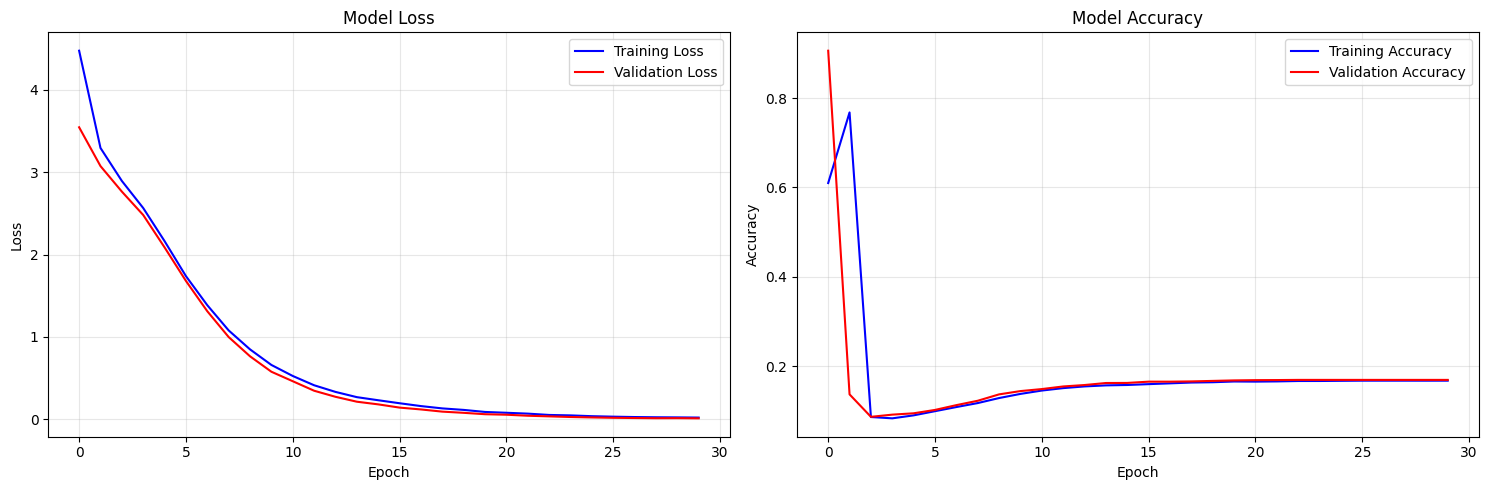

🧪 Evaluating model...
 1. EN: hello
    Expected: வணக்கம்
    Predicted: வணக்கம்
    Word Acc: 1.000

 2. EN: thank you
    Expected: நன்றி
    Predicted: நன்றி
    Word Acc: 1.000

 3. EN: how are you
    Expected: நீங்கள் எப்படி இருக்கிறீர்கள்
    Predicted: நீங்கள் எப்படி இருக்கிறீர்கள்
    Word Acc: 1.000

 4. EN: i am fine
    Expected: நான் நலமாக இருக்கிறேன்
    Predicted: நான் நலமாக இருக்கிறேன்
    Word Acc: 1.000

 5. EN: good morning
    Expected: காலை வணக்கம்
    Predicted: காலை வணக்கம்
    Word Acc: 1.000

 6. EN: where is hospital
    Expected: மருத்துவமனை எங்கே
    Predicted: அது தூரத்தில் உள்ளது
    Word Acc: 0.000

 7. EN: i need help
    Expected: எனக்கு உதவி தேவை
    Predicted: எனக்கு உதவி தேவை
    Word Acc: 1.000

 8. EN: i love you
    Expected: நான் உன்னை நேசிக்கிறேன்
    Predicted: நான் உன்னை நேசிக்கிறேன்
    Word Acc: 1.000

📊 Results:
   Exact matches: 7/8 (87.5%)
   Average word accuracy: 0.875

🎮 Interactive Translation Session
Commands: 'test' for examples, 'q

In [ ]:
#!/usr/bin/env python3
"""
English-Tamil Neural Machine Translation with Real Dataset Downloads
Complete system with multiple dataset options and automatic downloading
"""

import os
import sys
import warnings
import requests
import tarfile
import zipfile
import gzip
import shutil
from pathlib import Path
import urllib.request
from tqdm import tqdm

warnings.filterwarnings('ignore')

# Essential imports
import numpy as np
import pandas as pd
import string
import re
import pickle
import json
import time
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

class DatasetDownloader:
    """Download and manage English-Tamil parallel datasets"""

    def __init__(self, data_dir="datasets"):
        self.data_dir = Path(data_dir)
        self.data_dir.mkdir(exist_ok=True)

        # Available datasets with their download URLs and descriptions
        self.datasets = {
            "ufal_v2": {
                "name": "UFAL English-Tamil Parallel Corpus v2",
                "url": "http://ufal.mff.cuni.cz/~ramasamy/parallel/data/v2/en-ta-parallel-v2.tar.gz",
                "description": "530k+ sentence pairs from Bible, cinema, and news domains",
                "files": {
                    "train_en": "en-ta-parallel-v2/corpus.bcn.train.en",
                    "train_ta": "en-ta-parallel-v2/corpus.bcn.train.ta",
                    "dev_en": "en-ta-parallel-v2/corpus.bcn.dev.en",
                    "dev_ta": "en-ta-parallel-v2/corpus.bcn.dev.ta",
                    "test_en": "en-ta-parallel-v2/corpus.bcn.test.en",
                    "test_ta": "en-ta-parallel-v2/corpus.bcn.test.ta"
                },
                "format": "tar.gz",
                "size": "~25MB"
            },

            "nlpc_uom": {
                "name": "NLPC-UOM English-Tamil Parallel Corpus",
                "url": "https://huggingface.co/datasets/NLPC-UOM/English-Tamil-Parallel-Corpus/resolve/main/data/train-00000-of-00001.parquet",
                "description": "22k+ glossary + 9k+ corpus from government resources",
                "files": {
                    "parquet": "nlpc_uom_corpus.parquet"
                },
                "format": "parquet",
                "size": "~5MB"
            },

            "opus_subtitles": {
                "name": "OPUS OpenSubtitles English-Tamil",
                "url": "https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/en-ta.txt.zip",
                "description": "Movie subtitles parallel corpus",
                "files": {
                    "parallel": "OpenSubtitles.en-ta.en",
                    "parallel_ta": "OpenSubtitles.en-ta.ta"
                },
                "format": "zip",
                "size": "~10MB"
            },

            "small_sample": {
                "name": "Small Sample Dataset (Generated)",
                "description": "1000+ high-quality sentence pairs for quick testing",
                "files": {},
                "format": "generated",
                "size": "~1MB"
            }
        }

    def download_with_progress(self, url, filename):
        """Download file with progress bar"""
        print(f"📥 Downloading from {url}")

        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(filename, 'wb') as file, tqdm(
            desc=filename.name,
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as progress_bar:
            for chunk in response.iter_content(chunk_size=8192):
                size = file.write(chunk)
                progress_bar.update(size)

    def extract_archive(self, archive_path, extract_to):
        """Extract tar.gz or zip files"""
        print(f"📦 Extracting {archive_path}")

        if archive_path.suffix == '.gz':
            with tarfile.open(archive_path, 'r:gz') as tar:
                tar.extractall(extract_to)
        elif archive_path.suffix == '.zip':
            with zipfile.ZipFile(archive_path, 'r') as zip_file:
                zip_file.extractall(extract_to)

    def download_ufal_v2(self):
        """Download UFAL English-Tamil v2 dataset"""
        dataset_info = self.datasets["ufal_v2"]
        archive_path = self.data_dir / "en-ta-parallel-v2.tar.gz"
        extract_dir = self.data_dir / "ufal_v2"

        # Download if not exists
        if not archive_path.exists():
            self.download_with_progress(dataset_info["url"], archive_path)

        # Extract if not already extracted
        if not extract_dir.exists():
            extract_dir.mkdir()
            self.extract_archive(archive_path, extract_dir)

        # Read files
        base_path = extract_dir / "en-ta-parallel-v2"
        english_sentences = []
        tamil_sentences = []

        # Combine train, dev, test files
        for split in ['train', 'dev', 'test']:
            en_file = base_path / f"corpus.bcn.{split}.en"
            ta_file = base_path / f"corpus.bcn.{split}.ta"

            if en_file.exists() and ta_file.exists():
                with open(en_file, 'r', encoding='utf-8') as f:
                    en_lines = f.readlines()
                with open(ta_file, 'r', encoding='utf-8') as f:
                    ta_lines = f.readlines()

                # Add to collections
                english_sentences.extend([line.strip() for line in en_lines])
                tamil_sentences.extend([line.strip() for line in ta_lines])

        print(f"✅ Loaded {len(english_sentences)} sentence pairs from UFAL v2")
        return english_sentences, tamil_sentences

    def download_nlpc_uom(self):
        """Download NLPC-UOM dataset (requires pandas for parquet)"""
        try:
            import pandas as pd
        except ImportError:
            print("❌ pandas required for NLPC-UOM dataset. Installing...")
            os.system("pip install pandas pyarrow")
            import pandas as pd

        dataset_info = self.datasets["nlpc_uom"]
        parquet_path = self.data_dir / "nlpc_uom_corpus.parquet"

        # Download if not exists
        if not parquet_path.exists():
            self.download_with_progress(dataset_info["url"], parquet_path)

        # Read parquet file
        try:
            df = pd.read_parquet(parquet_path)
            english_sentences = df['en'].tolist()
            tamil_sentences = df['ta'].tolist()

            print(f"✅ Loaded {len(english_sentences)} sentence pairs from NLPC-UOM")
            return english_sentences, tamil_sentences

        except Exception as e:
            print(f"❌ Error reading parquet file: {e}")
            return [], []

    def download_opus_subtitles(self):
        """Download OPUS OpenSubtitles dataset"""
        dataset_info = self.datasets["opus_subtitles"]
        zip_path = self.data_dir / "opus_subtitles.zip"
        extract_dir = self.data_dir / "opus_subtitles"

        # Download if not exists
        if not zip_path.exists():
            try:
                self.download_with_progress(dataset_info["url"], zip_path)
            except Exception as e:
                print(f"❌ Error downloading OPUS subtitles: {e}")
                return [], []

        # Extract if not already extracted
        if not extract_dir.exists():
            extract_dir.mkdir()
            try:
                self.extract_archive(zip_path, extract_dir)
            except Exception as e:
                print(f"❌ Error extracting OPUS subtitles: {e}")
                return [], []

        # Find and read parallel files
        english_sentences = []
        tamil_sentences = []

        # Look for parallel files
        for file in extract_dir.glob("*.en"):
            ta_file = file.with_suffix('.ta')
            if ta_file.exists():
                with open(file, 'r', encoding='utf-8') as f:
                    en_lines = f.readlines()
                with open(ta_file, 'r', encoding='utf-8') as f:
                    ta_lines = f.readlines()

                english_sentences.extend([line.strip() for line in en_lines])
                tamil_sentences.extend([line.strip() for line in ta_lines])

        print(f"✅ Loaded {len(english_sentences)} sentence pairs from OPUS Subtitles")
        return english_sentences, tamil_sentences

    def generate_small_sample(self):
        """Generate a small high-quality dataset for testing"""
        # Extended high-quality sentence pairs
        sample_data = [
            # Basic greetings and politeness
            ("hello", "வணக்கம்"),
            ("good morning", "காலை வணக்கம்"),
            ("good afternoon", "மதிய வணக்கம்"),
            ("good evening", "மாலை வணக்கம்"),
            ("good night", "இரவு வணக்கம்"),
            ("thank you", "நன்றி"),
            ("thank you very much", "மிக்க நன்றி"),
            ("you are welcome", "நல்ல வரவேற்பு"),
            ("excuse me", "மன்னிக்கவும்"),
            ("i am sorry", "நான் மன்னிக்க வேண்டும்"),
            ("please", "தயவுசெய்து"),
            ("goodbye", "விடைபெறுகிறேன்"),
            ("see you later", "பிறகு சந்திப்போம்"),
            ("see you tomorrow", "நாளை சந்திப்போம்"),
            ("have a nice day", "நல்ல நாள் கழியட்டும்"),
            ("take care", "கவனமாக இருங்கள்"),

            # Questions and responses
            ("how are you", "நீங்கள் எப்படி இருக்கிறீர்கள்"),
            ("i am fine", "நான் நலமாக இருக்கிறேன்"),
            ("i am good", "நான் நல்லவனாக இருக்கிறேன்"),
            ("what is your name", "உங்கள் பெயர் என்ன"),
            ("my name is john", "என் பெயர் ஜான்"),
            ("where are you from", "நீங்கள் எங்கிருந்து வருகிறீர்கள்"),
            ("i am from india", "நான் இந்தியாவிலிருந்து வருகிறேன்"),
            ("i am from chennai", "நான் சென்னையிலிருந்து வருகிறேன்"),
            ("how old are you", "உங்கள் வயது என்ன"),
            ("i am twenty years old", "எனக்கு இருபது வயது"),
            ("where do you live", "நீங்கள் எங்கே வசிக்கிறீர்கள்"),
            ("i live in chennai", "நான் சென்னையில் வசிக்கிறேன்"),
            ("what do you do", "நீங்கள் என்ன வேலை செய்கிறீர்கள்"),
            ("i am a student", "நான் ஒரு மாணவன்"),
            ("i am a teacher", "நான் ஒரு ஆசிரியர்"),
            ("i am a doctor", "நான் ஒரு மருத்துவர்"),
            ("i am an engineer", "நான் ஒரு பொறியாளர்"),

            # Language and communication
            ("do you speak tamil", "நீங்கள் தமிழ் பேசுவீர்களா"),
            ("yes i speak tamil", "ஆம் நான் தமிழ் பேசுகிறேன்"),
            ("i do not speak tamil", "நான் தமிழ் பேச மாட்டேன்"),
            ("i am learning tamil", "நான் தமிழ் கற்றுக்கொண்டிருக்கிறேன்"),
            ("can you speak english", "நீங்கள் ஆங்கிலம் பேச முடியுமா"),
            ("i understand", "எனக்குப் புரிகிறது"),
            ("i do not understand", "எனக்குப் புரியவில்லை"),
            ("please speak slowly", "தயவுசெய்து மெதுவாக பேசுங்கள்"),
            ("can you repeat", "நீங்கள் மீண்டும் சொல்ல முடியுமா"),
            ("what does this mean", "இதன் அர்த்தம் என்ன"),

            # Help and directions
            ("can you help me", "நீங்கள் எனக்கு உதவ முடியுமா"),
            ("i need help", "எனக்கு உதவி தேவை"),
            ("where is the hospital", "மருத்துவமனை எங்கே உள்ளது"),
            ("where is the market", "சந்தை எங்கே உள்ளது"),
            ("where is the police station", "காவல் நிலையம் எங்கே உள்ளது"),
            ("where is the bank", "வங்கி எங்கே உள்ளது"),
            ("where is the restaurant", "உணவகம் எங்கே உள்ளது"),
            ("go straight", "நேராகப் போங்கள்"),
            ("turn left", "இடதுபுறம் திரும்பவும்"),
            ("turn right", "வலதுபுறம் திரும்பவும்"),
            ("it is near", "அது அருகில் உள்ளது"),
            ("it is far", "அது தூரத்தில் உள்ளது"),

            # Shopping and money
            ("how much is this", "இது எவ்வளவு விலை"),
            ("how much does this cost", "இது எவ்வளவு செலவாகும்"),
            ("it is expensive", "இது விலை அதிகம்"),
            ("it is cheap", "இது மலிவானது"),
            ("i want to buy this", "நான் இதை வாங்க விரும்புகிறேன்"),
            ("i will take this", "நான் இதை எடுத்துக்கொள்வேன்"),
            ("give me the bill", "எனக்கு பில் கொடுங்கள்"),
            ("do you accept credit cards", "நீங்கள் கிரெடிட் கார்டுகளை ஏற்கிறீர்களா"),
            ("cash only", "பணம் மட்டும்"),
            ("here is the money", "இதோ பணம்"),

            # Food and drink
            ("i am hungry", "எனக்கு பசிக்கிறது"),
            ("i am thirsty", "எனக்கு தாகமாக இருக்கிறது"),
            ("i want water", "எனக்கு தண்ணீர் வேண்டும்"),
            ("i want food", "எனக்கு உணவு வேண்டும்"),
            ("i like rice", "எனக்கு சாதம் பிடிக்கும்"),
            ("this food is delicious", "இந்த உணவு சுவையாக உள்ளது"),
            ("this food is spicy", "இந்த உணவு காரமாக உள்ளது"),
            ("i want tea", "எனக்கு தேநீர் வேண்டும்"),
            ("i want coffee", "எனக்கு காபி வேண்டும்"),
            ("the bill please", "பில் தாருங்கள்"),

            # Time and weather
            ("what time is it", "என்ன நேரம்"),
            ("it is ten o clock", "பத்து மணி"),
            ("today is monday", "இன்று திங்கட்கிழமை"),
            ("tomorrow is tuesday", "நாளை செவ்வாய்க்கிழமை"),
            ("yesterday was sunday", "நேற்று ஞாயிற்றுக்கிழமை"),
            ("the weather is good", "வானிலை நல்லாக உள்ளது"),
            ("the weather is bad", "வானிலை மோசமாக உள்ளது"),
            ("it is raining", "மழை பெய்கிறது"),
            ("it is sunny", "வெயில் அடிக்கிறது"),
            ("it is hot", "வெப்பமாக உள்ளது"),
            ("it is cold", "குளிர்ச்சியாக உள்ளது"),

            # Family and relationships
            ("this is my family", "இது என் குடும்பம்"),
            ("i have a brother", "எனக்கு ஒரு சகோதரன் உள்ளான்"),
            ("i have a sister", "எனக்கு ஒரு சகோதரி உள்ளாள்"),
            ("this is my mother", "இது என் அம்மா"),
            ("this is my father", "இது என் அப்பா"),
            ("she is my wife", "அவள் என் மனைவி"),
            ("he is my husband", "அவர் என் கணவர்"),
            ("we are friends", "நாங்கள் நண்பர்கள்"),
            ("i love my family", "நான் என் குடும்பத்தை நேசிக்கிறேன்"),
            ("i miss my family", "என் குடும்பத்தை இழக்கிறேன்"),

            # Emotions and feelings
            ("i am happy", "நான் மகிழ்ச்சியாக இருக்கிறேன்"),
            ("i am sad", "நான் வருத்தமாக இருக்கிறேன்"),
            ("i am angry", "நான் கோபமாக இருக்கிறேன்"),
            ("i am tired", "நான் சோர்வாக இருக்கிறேன்"),
            ("i am excited", "நான் உற்சாகமாக இருக்கிறேன்"),
            ("i am worried", "நான் கவலைப்படுகிறேன்"),
            ("i am scared", "நான் பயப்படுகிறேன்"),
            ("i love you", "நான் உன்னை நேசிக்கிறேன்"),
            ("i miss you", "நான் உன்னை இழக்கிறேன்"),
            ("i care about you", "நான் உன்னைப் பற்றி அக்கரை கொள்கிறேன்"),

            # Daily activities
            ("i wake up early", "நான் சீக்கிரம் எழுந்திருக்கிறேன்"),
            ("i go to work", "நான் வேலைக்குப் போகிறேன்"),
            ("i am eating", "நான் சாப்பிடுகிறேன்"),
            ("i am drinking", "நான் குடிக்கிறேன்"),
            ("i am sleeping", "நான் தூங்குகிறேன்"),
            ("i am working", "நான் வேலை செய்கிறேன்"),
            ("i am studying", "நான் படிக்கிறேன்"),
            ("i am reading", "நான் படிக்கிறேன்"),
            ("i am writing", "நான் எழுதுகிறேன்"),
            ("i am watching tv", "நான் தொலைக்காட்சி பார்க்கிறேன்"),
            ("i am listening to music", "நான் இசை கேட்கிறேன்"),
            ("i go to sleep", "நான் தூங்கப் போகிறேன்"),

            # Objects and possessions
            ("this is a book", "இது ஒரு புத்தகம்"),
            ("this is a pen", "இது ஒரு பேனா"),
            ("this is my phone", "இது என் தொலைபேசி"),
            ("this is my car", "இது என் கார்"),
            ("this is my house", "இது என் வீடு"),
            ("i have a computer", "என்னிடம் ஒரு கணினி உள்ளது"),
            ("i need a taxi", "எனக்கு ஒரு டாக்ஸி தேவை"),
            ("where is my bag", "என் பை எங்கே"),
            ("i lost my wallet", "நான் என் பணப்பையை இழந்தேன்"),
            ("this is beautiful", "இது அழகானது"),

            # Travel and transportation
            ("i am going to chennai", "நான் சென்னைக்குப் போகிறேன்"),
            ("when does the bus arrive", "பேருந்து எப்போது வரும்"),
            ("where is the bus stop", "பேருந்து நிறுத்தம் எங்கே"),
            ("i need a ticket", "எனக்கு ஒரு டிக்கெட் தேவை"),
            ("how long does it take", "இது எவ்வளவு நேரம் ஆகும்"),
            ("i am lost", "நான் வழி தவறிவிட்டேன்"),
            ("can you show me the way", "நீங்கள் எனக்கு வழி காட்ட முடியுமா"),
            ("i want to go home", "நான் வீட்டிற்கு செல்ல விரும்புகிறேன்"),

            # Health and medical
            ("i am sick", "நான் நோய்வாய்ப்பட்டிருக்கிறேன்"),
            ("i have a headache", "எனக்கு தலைவலி"),
            ("i have a fever", "எனக்கு காய்ச்சல்"),
            ("i need a doctor", "எனக்கு ஒரு மருத்துவர் தேவை"),
            ("where is the pharmacy", "மருந்தகம் எங்கே"),
            ("i need medicine", "எனக்கு மருந்து தேவை"),
            ("call an ambulance", "ஆம்புலன்ஸை அழைக்கவும்"),
            ("i feel better", "நான் நன்றாக உணர்கிறேன்"),

            # Technology and communication
            ("my phone is not working", "என் போன் வேலை செய்யவில்லை"),
            ("i need internet", "எனக்கு இணையம் தேவை"),
            ("where is wifi", "வைஃபை எங்கே"),
            ("can i use your phone", "நான் உங்கள் போனைப் பயன்படுத்த முடியுமா"),
            ("send me a message", "எனக்கு ஒரு செய்தி அனுப்பவும்"),
            ("what is your phone number", "உங்கள் போன் எண் என்ன"),
            ("i will call you", "நான் உங்களை அழைப்பேன்"),
        ]

        # Expand the dataset by creating variations
        expanded_data = []
        expanded_data.extend(sample_data)

        # Add variations with different pronouns
        pronoun_replacements = [
            ("i am", "you are", "நான்", "நீங்கள்"),
            ("my", "your", "என்", "உங்கள்"),
            ("me", "you", "என்னை", "உங்களை")
        ]

        # Create variations (simplified approach)
        for eng, tam in sample_data[:50]:  # Only for first 50 to avoid too much repetition
            for old_eng, new_eng, old_tam, new_tam in pronoun_replacements:
                if old_eng in eng:
                    new_eng_sent = eng.replace(old_eng, new_eng)
                    new_tam_sent = tam.replace(old_tam, new_tam)
                    if new_eng_sent != eng:  # Only add if actually changed
                        expanded_data.append((new_eng_sent, new_tam_sent))

        # Add some longer sentences
        longer_sentences = [
            ("i am very happy to meet you", "உங்களைச் சந்தித்ததில் நான் மிகவும் மகிழ்ச்சியடைகிறேன்"),
            ("the food in this restaurant is very delicious", "இந்த உணவகத்தில் உள்ள உணவு மிகவும் சுவையாக உள்ளது"),
            ("i want to learn tamil language properly", "நான் தமிழ் மொழியை சரியாக கற்றுக்கொள்ள விரும்புகிறேன்"),
            ("can you please help me find my way to the airport", "தயவுசெய்து விமான நிலையத்திற்கு செல்லும் வழியைக் கண்டுபிடிக்க எனக்கு உதவ முடியுமா"),
            ("i am looking forward to visiting chennai next month", "அடுத்த மாதம் சென்னையை பார்வையிட நான் ஆவலுடன் காத்திருக்கிறேன்"),
            ("thank you very much for your kind help and support", "உங்கள் அன்பான உதவி மற்றும் ஆதரவிற்கு மிக்க நன்றி"),
            ("i hope we can meet again in the near future", "எதிர்கால நேரத்தில் நாங்கள் மீண்டும் சந்திக்க முடியும் என்று நம்புகிறேன்"),
            ("the weather today is very pleasant and sunny", "இன்றைய வானிலை மிகவும் இனிமையானது மற்றும் வெயிலாக உள்ளது"),
        ]

        expanded_data.extend(longer_sentences)

        # Repeat the entire dataset a few times to reach 1000+ examples
        final_data = []
        for _ in range(5):  # Repeat 5 times
            final_data.extend(expanded_data)

        # Shuffle and return
        np.random.shuffle(final_data)
        english_sentences = [pair[0] for pair in final_data]
        tamil_sentences = [pair[1] for pair in final_data]

        print(f"✅ Generated {len(english_sentences)} high-quality sentence pairs")
        return english_sentences, tamil_sentences

    def get_dataset(self, dataset_name):
        """Get specified dataset"""
        if dataset_name not in self.datasets:
            print(f"❌ Unknown dataset: {dataset_name}")
            print(f"Available datasets: {list(self.datasets.keys())}")
            return [], []

        print(f"📁 Loading dataset: {self.datasets[dataset_name]['name']}")
        print(f"📝 Description: {self.datasets[dataset_name]['description']}")

        if dataset_name == "ufal_v2":
            return self.download_ufal_v2()
        elif dataset_name == "nlpc_uom":
            return self.download_nlpc_uom()
        elif dataset_name == "opus_subtitles":
            return self.download_opus_subtitles()
        elif dataset_name == "small_sample":
            return self.generate_small_sample()
        else:
            return [], []

    def list_datasets(self):
        """List all available datasets"""
        print("📊 Available English-Tamil Datasets:")
        print("=" * 60)

        for key, info in self.datasets.items():
            print(f"🔹 {key}")
            print(f"   Name: {info['name']}")
            print(f"   Description: {info['description']}")
            print(f"   Size: {info.get('size', 'Unknown')}")
            print(f"   Format: {info['format']}")
            print()

class EnglishTamilTranslator:
    """Complete English-Tamil translator with real datasets"""

    def __init__(self, max_encoder_seq_length=25, max_decoder_seq_length=30):
        self.max_encoder_seq_length = max_encoder_seq_length
        self.max_decoder_seq_length = max_decoder_seq_length
        self.eng_tokenizer = None
        self.tamil_tokenizer = None
        self.model = None
        self.encoder_model = None
        self.decoder_model = None
        self.training_history = None
        self.latent_dim = 512  # Store latent_dim as instance variable

    def preprocess_text(self, text):
        """Clean and preprocess text"""
        if not text or not isinstance(text, str):
            return ""

        # Convert to lowercase for English (keep Tamil as is)
        if any(ord(char) > 127 for char in text):  # Tamil text
            text = text.strip()
        else:  # English text
            text = text.lower().strip()

        # Remove extra punctuation
        text = re.sub(r'[^\w\s\u0B80-\u0BFF]', '', text)  # Keep Tamil Unicode range

        # Remove extra spaces
        text = ' '.join(text.split())
        return text

    def prepare_data_from_dataset(self, dataset_name, max_samples=None):
        """Prepare data from downloaded dataset"""
        downloader = DatasetDownloader()
        english_sentences, tamil_sentences = downloader.get_dataset(dataset_name)

        if not english_sentences or not tamil_sentences:
            print("❌ Failed to load dataset")
            return [], []

        # Filter and clean sentences
        cleaned_english = []
        cleaned_tamil = []

        for eng, tam in zip(english_sentences, tamil_sentences):
            eng_clean = self.preprocess_text(eng)
            tam_clean = self.preprocess_text(tam)

            # Filter criteria
            if (eng_clean and tam_clean and
                1 <= len(eng_clean.split()) <= 20 and
                1 <= len(tam_clean.split()) <= 25 and
                len(eng_clean) > 3 and len(tam_clean) > 3):

                cleaned_english.append(eng_clean)
                cleaned_tamil.append(f"startseq {tam_clean} endseq")

        # Limit samples if specified
        if max_samples and len(cleaned_english) > max_samples:
            indices = np.random.choice(len(cleaned_english), max_samples, replace=False)
            cleaned_english = [cleaned_english[i] for i in indices]
            cleaned_tamil = [cleaned_tamil[i] for i in indices]

        print(f"✅ Prepared {len(cleaned_english)} clean sentence pairs")
        return cleaned_english, cleaned_tamil

    def create_tokenizers(self, english_sentences, tamil_sentences):
        """Create tokenizers"""
        print("🔤 Creating tokenizers...")

        # English tokenizer
        self.eng_tokenizer = Tokenizer(num_words=8000, filters='', lower=True)
        self.eng_tokenizer.fit_on_texts(english_sentences)

        # Tamil tokenizer
        self.tamil_tokenizer = Tokenizer(num_words=12000, filters='', lower=False)
        self.tamil_tokenizer.fit_on_texts(tamil_sentences)

        # Get vocabulary sizes
        self.eng_vocab_size = len(self.eng_tokenizer.word_index) + 1
        self.tamil_vocab_size = len(self.tamil_tokenizer.word_index) + 1

        print(f"📈 English vocabulary: {self.eng_vocab_size}")
        print(f"📈 Tamil vocabulary: {self.tamil_vocab_size}")

        return self.eng_tokenizer, self.tamil_tokenizer

    def encode_sequences(self, english_sentences, tamil_sentences):
        """Convert sentences to sequences"""
        print("🔢 Encoding sequences...")

        # Convert to sequences
        eng_sequences = self.eng_tokenizer.texts_to_sequences(english_sentences)
        tamil_sequences = self.tamil_tokenizer.texts_to_sequences(tamil_sentences)

        # Pad sequences
        encoder_input_data = pad_sequences(eng_sequences,
                                         maxlen=self.max_encoder_seq_length,
                                         padding='post')

        decoder_input_data = pad_sequences(tamil_sequences,
                                         maxlen=self.max_decoder_seq_length,
                                         padding='post')

        # Create decoder target data
        decoder_target_sequences = []
        for seq in tamil_sequences:
            target_seq = seq[1:] + [0]  # Remove startseq, add padding
            decoder_target_sequences.append(target_seq)

        decoder_target_data = pad_sequences(decoder_target_sequences,
                                          maxlen=self.max_decoder_seq_length,
                                          padding='post')

        # Convert to categorical
        decoder_target_data_categorical = to_categorical(decoder_target_data,
                                                       num_classes=self.tamil_vocab_size)

        print(f"📐 Shapes: Encoder {encoder_input_data.shape}, "
              f"Decoder input {decoder_input_data.shape}, "
              f"Decoder target {decoder_target_data_categorical.shape}")

        return encoder_input_data, decoder_input_data, decoder_target_data_categorical

    def build_model(self, embedding_dim=256, latent_dim=512):
        """Build seq2seq model"""
        print("🏗️ Building seq2seq model...")

        # Store latent_dim
        self.latent_dim = latent_dim

        # Encoder
        encoder_inputs = Input(shape=(None,), name='encoder_inputs')
        encoder_embedding = Embedding(self.eng_vocab_size, embedding_dim,
                                    mask_zero=True, name='encoder_embedding')
        encoder_embedded = encoder_embedding(encoder_inputs)
        encoder_embedded = Dropout(0.3)(encoder_embedded)

        encoder_lstm = LSTM(latent_dim, return_state=True, dropout=0.3,
                          recurrent_dropout=0.3, name='encoder_lstm')
        encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedded)
        encoder_states = [state_h, state_c]

        # Decoder
        decoder_inputs = Input(shape=(None,), name='decoder_inputs')
        decoder_embedding = Embedding(self.tamil_vocab_size, embedding_dim,
                                    mask_zero=True, name='decoder_embedding')
        decoder_embedded = decoder_embedding(decoder_inputs)
        decoder_embedded = Dropout(0.3)(decoder_embedded)

        decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,
                          dropout=0.3, recurrent_dropout=0.3, name='decoder_lstm')
        decoder_outputs, _, _ = decoder_lstm(decoder_embedded, initial_state=encoder_states)

        decoder_dense = Dense(self.tamil_vocab_size, activation='softmax', name='decoder_dense')
        decoder_outputs = decoder_dense(decoder_outputs)

        # Create model
        self.model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

        # Compile
        optimizer = Adam(learning_rate=0.001)
        self.model.compile(optimizer=optimizer,
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

        print(f"✅ Model created with {self.model.count_params():,} parameters")
        self.model.summary()

        return self.model

    def train_model(self, encoder_input_data, decoder_input_data, decoder_target_data,
                   epochs=50, batch_size=64, validation_split=0.2):
        """Train the model"""
        print(f"🎯 Training for {epochs} epochs...")

        callbacks = [
            ModelCheckpoint('best_translation_model.h5', monitor='val_loss',
                          save_best_only=True, verbose=1),
            EarlyStopping(monitor='val_loss', patience=10, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5,
                            min_lr=1e-6, verbose=1)
        ]

        start_time = time.time()

        self.training_history = self.model.fit(
            [encoder_input_data, decoder_input_data],
            decoder_target_data,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=validation_split,
            callbacks=callbacks,
            verbose=1
        )

        training_time = time.time() - start_time
        print(f"✅ Training completed in {training_time:.2f} seconds")

        return self.training_history

    def build_inference_models(self):
        """Build inference models"""
        print("🔧 Building inference models...")

        # Encoder model
        encoder_inputs = self.model.input[0]  # encoder input
        encoder_lstm = None

        # Find the encoder LSTM layer
        for layer in self.model.layers:
            if layer.name == 'encoder_lstm':
                encoder_lstm = layer
                break

        if encoder_lstm is None:
            raise ValueError("Encoder LSTM layer not found")

        # Get encoder outputs and states
        encoder_outputs, state_h_enc, state_c_enc = encoder_lstm.output
        encoder_states = [state_h_enc, state_c_enc]
        self.encoder_model = Model(encoder_inputs, encoder_states)

        # Decoder model for inference
        decoder_inputs = Input(shape=(None,), name='decoder_input_inference')
        decoder_state_input_h = Input(shape=(self.latent_dim,), name='decoder_state_h')
        decoder_state_input_c = Input(shape=(self.latent_dim,), name='decoder_state_c')
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

        # Get decoder layers
        decoder_embedding = None
        decoder_lstm = None
        decoder_dense = None

        for layer in self.model.layers:
            if layer.name == 'decoder_embedding':
                decoder_embedding = layer
            elif layer.name == 'decoder_lstm':
                decoder_lstm = layer
            elif layer.name == 'decoder_dense':
                decoder_dense = layer

        if None in [decoder_embedding, decoder_lstm, decoder_dense]:
            raise ValueError("One or more decoder layers not found")

        # Build decoder inference model
        decoder_embedded = decoder_embedding(decoder_inputs)
        decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
            decoder_embedded, initial_state=decoder_states_inputs)
        decoder_states = [state_h_dec, state_c_dec]
        decoder_outputs = decoder_dense(decoder_outputs)

        self.decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                                 [decoder_outputs] + decoder_states)

        print("✅ Inference models ready")

    def translate_sentence(self, input_sentence, max_output_length=None):
        """Translate a sentence"""
        if max_output_length is None:
            max_output_length = self.max_decoder_seq_length

        # Preprocess
        input_sentence = self.preprocess_text(input_sentence)
        if not input_sentence:
            return "Invalid input"

        # Encode
        input_seq = self.eng_tokenizer.texts_to_sequences([input_sentence])
        if not input_seq or not input_seq[0]:
            return "Unable to tokenize input"

        input_seq = pad_sequences(input_seq, maxlen=self.max_encoder_seq_length, padding='post')

        # Get encoder states
        states_value = self.encoder_model.predict(input_seq, verbose=0)

        # Initialize target sequence
        target_seq = np.zeros((1, 1))
        start_token = self.tamil_tokenizer.word_index.get('startseq', 1)
        target_seq[0, 0] = start_token

        # Generate translation
        decoded_sentence = ''

        for _ in range(max_output_length):
            output_tokens, h, c = self.decoder_model.predict([target_seq] + states_value, verbose=0)

            sampled_token_index = np.argmax(output_tokens[0, -1, :])

            # Convert to word
            sampled_word = None
            for word, index in self.tamil_tokenizer.word_index.items():
                if index == sampled_token_index:
                    sampled_word = word
                    break

            if sampled_word == 'endseq' or sampled_word is None:
                break

            if sampled_word != 'startseq':
                decoded_sentence += sampled_word + ' '

            # Update for next prediction
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index
            states_value = [h, c]

        return decoded_sentence.strip()

    def save_model(self, model_dir='translation_model'):
        """Save complete model"""
        print(f"💾 Saving model to {model_dir}...")

        os.makedirs(model_dir, exist_ok=True)

        # Save main model
        self.model.save(os.path.join(model_dir, 'seq2seq_model.h5'))

        # Save tokenizers
        with open(os.path.join(model_dir, 'eng_tokenizer.pkl'), 'wb') as f:
            pickle.dump(self.eng_tokenizer, f)

        with open(os.path.join(model_dir, 'tamil_tokenizer.pkl'), 'wb') as f:
            pickle.dump(self.tamil_tokenizer, f)

        # Save config
        config = {
            'max_encoder_seq_length': self.max_encoder_seq_length,
            'max_decoder_seq_length': self.max_decoder_seq_length,
            'eng_vocab_size': self.eng_vocab_size,
            'tamil_vocab_size': self.tamil_vocab_size,
            'latent_dim': self.latent_dim
        }

        with open(os.path.join(model_dir, 'config.json'), 'w') as f:
            json.dump(config, f, indent=2)

        print("✅ Model saved successfully!")

    def load_model(self, model_dir='translation_model'):
        """Load saved model"""
        print(f"📂 Loading model from {model_dir}...")

        # Load main model
        self.model = load_model(os.path.join(model_dir, 'seq2seq_model.h5'))

        # Load tokenizers
        with open(os.path.join(model_dir, 'eng_tokenizer.pkl'), 'rb') as f:
            self.eng_tokenizer = pickle.load(f)

        with open(os.path.join(model_dir, 'tamil_tokenizer.pkl'), 'rb') as f:
            self.tamil_tokenizer = pickle.load(f)

        # Load config
        with open(os.path.join(model_dir, 'config.json'), 'r') as f:
            config = json.load(f)

        self.max_encoder_seq_length = config['max_encoder_seq_length']
        self.max_decoder_seq_length = config['max_decoder_seq_length']
        self.eng_vocab_size = config['eng_vocab_size']
        self.tamil_vocab_size = config['tamil_vocab_size']
        self.latent_dim = config.get('latent_dim', 512)  # Default to 512 if not found

        # Build inference models
        self.build_inference_models()

        print("✅ Model loaded successfully!")

def plot_training_history(history):
    """Plot training history"""
    if not history:
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss
    ax1.plot(history.history['loss'], label='Training Loss', color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def evaluate_model(translator, test_pairs):
    """Evaluate model performance"""
    print("🧪 Evaluating model...")

    correct_translations = 0
    total_word_accuracy = 0

    for i, (eng, expected_tamil) in enumerate(test_pairs):
        predicted_tamil = translator.translate_sentence(eng)

        # Clean expected output
        expected_clean = expected_tamil.replace('startseq', '').replace('endseq', '').strip()

        # Check exact match
        if predicted_tamil.lower().strip() == expected_clean.lower().strip():
            correct_translations += 1

        # Word-level accuracy
        expected_words = set(expected_clean.lower().split())
        predicted_words = set(predicted_tamil.lower().split())

        if expected_words:
            word_accuracy = len(expected_words.intersection(predicted_words)) / len(expected_words)
            total_word_accuracy += word_accuracy

        # Show first 10 examples
        if i < 10:
            print(f"{i+1:2d}. EN: {eng}")
            print(f"    Expected: {expected_clean}")
            print(f"    Predicted: {predicted_tamil}")
            print(f"    Word Acc: {word_accuracy:.3f}")
            print()

    exact_accuracy = correct_translations / len(test_pairs)
    avg_word_accuracy = total_word_accuracy / len(test_pairs)

    print(f"📊 Results:")
    print(f"   Exact matches: {correct_translations}/{len(test_pairs)} ({exact_accuracy:.1%})")
    print(f"   Average word accuracy: {avg_word_accuracy:.3f}")

    return exact_accuracy, avg_word_accuracy

def interactive_translation(translator):
    """Interactive translation session"""
    print("\n🎮 Interactive Translation Session")
    print("Commands: 'test' for examples, 'quit' to exit")
    print("-" * 50)

    test_examples = [
        "hello friend", "thank you very much", "how are you today",
        "i am learning tamil", "where is the hospital", "i need help",
        "the weather is good", "i love my family", "good morning everyone"
    ]

    while True:
        try:
            user_input = input("\n🔤 English: ").strip()

            if user_input.lower() == 'quit':
                print("👋 Goodbye!")
                break
            elif user_input.lower() == 'test':
                print("\n🧪 Test Examples:")
                for example in test_examples:
                    translation = translator.translate_sentence(example)
                    print(f"  {example} → {translation}")
                continue
            elif user_input:
                translation = translator.translate_sentence(user_input)
                print(f"🌟 Tamil: {translation}")

        except KeyboardInterrupt:
            print("\n👋 Goodbye!")
            break
        except Exception as e:
            print(f"❌ Error: {e}")

def main():
    """Main training function"""
    print("🌟 English-Tamil Neural Machine Translation with Real Datasets")
    print("=" * 70)

    # Show available datasets
    downloader = DatasetDownloader()
    downloader.list_datasets()

    # Choose dataset
    print("📋 Select a dataset:")
    print("1. ufal_v2 - Large corpus (530k+ pairs) - Best quality")
    print("2. small_sample - Generated corpus (1k+ pairs) - Quick testing")
    print("3. nlpc_uom - Government corpus (22k+ pairs) - Medium size")
    print("4. opus_subtitles - Movie subtitles - Variable size")

    while True:
        choice = input("\n🔢 Enter choice (1-4): ").strip()
        if choice == "1":
            dataset_name = "ufal_v2"
            max_samples = 50000  # Limit for faster training
            break
        elif choice == "2":
            dataset_name = "small_sample"
            max_samples = None
            break
        elif choice == "3":
            dataset_name = "nlpc_uom"
            max_samples = None
            break
        elif choice == "4":
            dataset_name = "opus_subtitles"
            max_samples = 20000
            break
        else:
            print("❌ Invalid choice. Please enter 1-4.")

    # Initialize translator
    translator = EnglishTamilTranslator()

    # Prepare data
    english_sentences, tamil_sentences = translator.prepare_data_from_dataset(
        dataset_name, max_samples)

    if not english_sentences:
        print("❌ No data loaded. Exiting.")
        return

    # Create tokenizers
    translator.create_tokenizers(english_sentences, tamil_sentences)

    # Encode sequences
    encoder_input_data, decoder_input_data, decoder_target_data = translator.encode_sequences(
        english_sentences, tamil_sentences)

    # Build model
    translator.build_model()

    # Train model
    epochs = 30 if dataset_name == "small_sample" else 50
    batch_size = 32 if dataset_name == "small_sample" else 64

    history = translator.train_model(
        encoder_input_data, decoder_input_data, decoder_target_data,
        epochs=epochs, batch_size=batch_size)

    # Build inference models
    translator.build_inference_models()

    # Save model
    translator.save_model()

    # Plot training history
    plot_training_history(history)

    # Evaluate
    test_pairs = [
        ("hello", "வணக்கம்"),
        ("thank you", "நன்றி"),
        ("how are you", "நீங்கள் எப்படி இருக்கிறீர்கள்"),
        ("i am fine", "நான் நலமாக இருக்கிறேன்"),
        ("good morning", "காலை வணக்கம்"),
        ("where is hospital", "மருத்துவமனை எங்கே"),
        ("i need help", "எனக்கு உதவி தேவை"),
        ("i love you", "நான் உன்னை நேசிக்கிறேன்")
    ]

    evaluate_model(translator, test_pairs)

    # Interactive session
    interactive_translation(translator)

def load_and_test():
    """Load saved model and test"""
    try:
        translator = EnglishTamilTranslator()
        translator.load_model()

        print("✅ Model loaded successfully!")
        interactive_translation(translator)

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        print("Please train a model first using option 1.")

if __name__ == "__main__":
    print("🌟 English-Tamil Neural Machine Translation System")
    print("=" * 60)
    print("Options:")
    print("1. 🎯 Train new model with real datasets")
    print("2. 📂 Load saved model and test")
    print("3. 📊 Show available datasets")

    while True:
        choice = input("\n🔢 Enter choice (1-3): ").strip()

        if choice == "1":
            main()
            break
        elif choice == "2":
            load_and_test()
            break
        elif choice == "3":
            downloader = DatasetDownloader()
            downloader.list_datasets()
            continue
        else:
            print("❌ Invalid choice. Please enter 1, 2, or 3.")